In [376]:
import pandas as pd, numpy as np, datetime as dt, os, re, time
import operator, requests

In [2]:
from spotify_keys import CLIENT_ID, CLIENT_SECRET, SPOTIFY_BEARER_KEY

# There are 2 Main Sources of Data:
* Data World Data
    * hot100.csv
        * Complete Hot 100 Data from 1999 to 2019. corresponds to 29,154 Songs
    * audioFeatures.csv
        * Spotify Audio Features of Billboard Songs corresponds to 28,377 Songs
* Kaggle Data
    * billboardHot100_1999-2019.csv
        * Incomplete Hot 100 Data from 1999 to 2019
    * songAttributes_1999-2019.csv
        * Spotify Attributes for 150,000+ songs
        * They do not have a direct correspondence with the Hot 100 Songs. But provide a meaningful sample of Songs.
            * If I recreate the distribution of songs by Top level Genre in the Billboard Hot100 I should be able to get a meaningful sample of songs to compare against the more popular Songs

<h1 style="color: #23ADAA" > GOALS:</h1>
<ol>
<li> Locate the Songs with Missing Attributes in audioFeatures.csv</li>
<li> Compare those missing against Songs in the other song Attributes file.</li>
<li> Create a Structured Data Base with Tables corresponding to:
    <ul>
    <li> Time Series of Songs over each week with the wanted Spotify attributes and a column for Top level Genre.</li>
    <li> A Sample of Songs that were released in the same time period (1999 - 2019) and Have the Same Distribution of the Top Level Genre as The Hot 100. </li>
    </ul>
</ol>
<br>
<p>These tables will help generate a Horse Race Chart that will show Chart Progression Over Time and Radar Charts Graphing the Hot 100 Attributes Against The Sample of Other Songs. There will additionally be aggregate statistics about the overall year in music on how music was structured and experienced given the attributes of popular songs and all other songs we have.</p>

In [3]:
# Main Data
df_hot = pd.read_csv("../data/raw/hot100.csv")

In [4]:
df_hot.shape

(325695, 10)

In [5]:
df_hot.head()

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
0,http://www.billboard.com/charts/hot-100/1963-0...,6/1/1963,11,Still,Bill Anderson,StillBill Anderson,1.0,17.0,11.0,8.0
1,http://www.billboard.com/charts/hot-100/1967-0...,1/7/1967,11,Coming Home Soldier,Bobby Vinton,Coming Home SoldierBobby Vinton,1.0,17.0,11.0,8.0
2,http://www.billboard.com/charts/hot-100/1971-0...,7/3/1971,11,She's Not Just Another Woman,The 8th Day,She's Not Just Another WomanThe 8th Day,1.0,17.0,11.0,8.0
3,http://www.billboard.com/charts/hot-100/1975-1...,11/29/1975,11,Saturday Night,Bay City Rollers,Saturday NightBay City Rollers,1.0,17.0,11.0,8.0
4,http://www.billboard.com/charts/hot-100/1979-0...,9/29/1979,11,Pop Muzik,M,Pop MuzikM,1.0,17.0,11.0,8.0


In [6]:
df_hot.WeekID = pd.to_datetime(df_hot.WeekID)

In [7]:
df_hot.sort_values("WeekID")

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
17651,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,72,Stupid Cupid,Connie Francis,Stupid CupidConnie Francis,1.0,NaN,72.0,1.0
6984,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,54,Nel Blu Dipinto Di Blu (Volaré),Domenico Modugno,Nel Blu Dipinto Di Blu (Volaré)Domenico Modugno,1.0,NaN,54.0,1.0
22741,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,87,Jealousy,Kitty Wells,JealousyKitty Wells,1.0,NaN,87.0,1.0
294973,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,5,When,Kalin Twins,WhenKalin Twins,1.0,NaN,5.0,1.0
318351,http://www.billboard.com/charts/hot-100/1958-0...,1958-08-02,79,The Bird On My Head,David Seville,The Bird On My HeadDavid Seville,1.0,NaN,79.0,1.0
...,...,...,...,...,...,...,...,...,...,...
309370,https://www.billboard.com/charts/hot-100/2020-...,2020-12-26,26,Happy Holiday / The Holiday Season,Andy Williams,Happy Holiday / The Holiday SeasonAndy Williams,NaN,NaN,NaN,NaN
309369,https://www.billboard.com/charts/hot-100/2020-...,2020-12-26,25,For The Night,Pop Smoke Featuring Lil Baby & DaBaby,For The NightPop Smoke Featuring Lil Baby & Da...,NaN,NaN,NaN,NaN
309427,https://www.billboard.com/charts/hot-100/2020-...,2020-12-26,83,Love You Like I Used To,Russell Dickerson,Love You Like I Used ToRussell Dickerson,NaN,NaN,NaN,NaN
309348,https://www.billboard.com/charts/hot-100/2020-...,2020-12-26,4,Jingle Bell Rock,Bobby Helms,Jingle Bell RockBobby Helms,NaN,NaN,NaN,NaN


In [8]:
# We only want data from 1999 - 2020
df_hot = df_hot[(df_hot.WeekID >= dt.datetime(1999, 1, 1)) & (df_hot.WeekID < dt.datetime(2020, 1, 1))].reset_index(drop=True)

In [9]:
df_hot.shape

(109600, 10)

In [10]:
df_hot

,url,WeekID,Week Position,Song,Performer,SongID,Instance,Previous Week Position,Peak Position,Weeks on Chart
0,http://www.billboard.com/charts/hot-100/1999-0...,1999-03-27,11,All Night Long,Faith Evans Featuring Puff Daddy,All Night LongFaith Evans Featuring Puff Daddy,1.0,19.0,11.0,8.0
1,https://www.billboard.com/charts/hot-100/2019-...,2019-12-07,11,Dance Monkey,Tones And I,Dance MonkeyTones And I,1.0,19.0,11.0,8.0
2,http://www.billboard.com/charts/hot-100/2005-1...,2005-10-15,11,Run It!,Chris Brown,Run It!Chris Brown,1.0,24.0,11.0,8.0
3,http://www.billboard.com/charts/hot-100/2010-0...,2010-03-27,12,Baby,Justin Bieber Featuring Ludacris,BabyJustin Bieber Featuring Ludacris,1.0,14.0,5.0,8.0
4,https://www.billboard.com/charts/hot-100/2018-...,2018-04-07,12,Pray For Me,The Weeknd & Kendrick Lamar,Pray For MeThe Weeknd & Kendrick Lamar,1.0,10.0,7.0,8.0
...,...,...,...,...,...,...,...,...,...,...
109595,https://www.billboard.com/charts/hot-100/2018-...,2018-03-17,38,You Make It Easy,Jason Aldean,You Make It EasyJason Aldean,1.0,38.0,28.0,6.0
109596,https://www.billboard.com/charts/hot-100/2018-...,2018-03-24,34,You Make It Easy,Jason Aldean,You Make It EasyJason Aldean,1.0,38.0,28.0,7.0
109597,https://www.billboard.com/charts/hot-100/2018-...,2018-03-31,36,You Make It Easy,Jason Aldean,You Make It EasyJason Aldean,1.0,34.0,28.0,8.0
109598,https://www.billboard.com/charts/hot-100/2018-...,2018-04-07,34,You Make It Easy,Jason Aldean,You Make It EasyJason Aldean,1.0,36.0,28.0,9.0


In [11]:
# Data Structure: Song Name, Artist, Position 1-100, Date of Billboard Chart Release/Update, Song's Position at t-1, Cumsum of Weeks, Appearence/Reappearence of Song, Artist-Song Concatentation
df_hot = df_hot.loc[:, ["Song", "Performer", "Week Position", "WeekID","Previous Week Position", "Peak Position", "Weeks on Chart", "Instance", "SongID"]]

In [12]:
df_hot = df_hot.assign(Week_No = lambda x: x.WeekID.apply(dt.datetime.strftime, format="%U"))

In [13]:
df_hot = df_hot.sort_values(["WeekID", "Week Position"]).reset_index(drop=True)

In [14]:
df_hot.Week_No.value_counts()

36    2100
05    2100
24    2100
07    2100
06    2100
16    2100
01    2100
48    2100
03    2100
30    2100
49    2100
17    2100
22    2100
33    2100
04    2100
23    2100
28    2100
47    2100
39    2100
13    2100
50    2100
45    2100
51    2100
29    2100
14    2100
19    2100
10    2100
26    2100
34    2100
20    2100
46    2100
31    2100
25    2100
38    2100
08    2100
18    2100
40    2100
15    2100
41    2100
35    2100
32    2100
42    2100
21    2100
37    2100
11    2100
27    2100
09    2100
12    2100
02    2100
43    2100
44    2100
00    1800
52     700
Name: Week_No, dtype: int64

In [15]:
df_hot.head(10)

,Song,Performer,Week Position,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID,Week_No
0,I'm Your Angel,R. Kelly & Celine Dion,1,1999-01-02,1.0,1.0,5.0,1.0,I'm Your AngelR. Kelly & Celine Dion,00
1,Nobody's Supposed To Be Here,Deborah Cox,2,1999-01-02,2.0,2.0,14.0,1.0,Nobody's Supposed To Be HereDeborah Cox,00
2,Lately,Divine,3,1999-01-02,3.0,1.0,17.0,1.0,LatelyDivine,00
3,...Baby One More Time,Britney Spears,4,1999-01-02,5.0,4.0,7.0,1.0,...Baby One More TimeBritney Spears,00
4,Because Of You,98 Degrees,5,1999-01-02,6.0,3.0,14.0,1.0,Because Of You98 Degrees,00
5,From This Moment On,Shania Twain,6,1999-01-02,4.0,4.0,5.0,1.0,From This Moment OnShania Twain,00
6,Doo Wop (That Thing),Lauryn Hill,7,1999-01-02,7.0,1.0,8.0,1.0,Doo Wop (That Thing)Lauryn Hill,00
7,Trippin',Total Featuring Missy Elliott,8,1999-01-02,12.0,8.0,9.0,1.0,Trippin'Total Featuring Missy Elliott,00
8,Have You Ever?,Brandy,9,1999-01-02,9.0,9.0,5.0,1.0,Have You Ever?Brandy,00
9,Love Like This,Faith Evans,10,1999-01-02,8.0,7.0,8.0,1.0,Love Like ThisFaith Evans,00


In [16]:
# Number of Unique Songs
df_hot.SongID.unique().shape

(8307,)

In [17]:
# We have Equla Numbers for All Billboard Positions and NULLS Only on Song's First Week on Chart
df_hot.groupby("Week Position").count().sort_values("WeekID")

,Song,Performer,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID,Week_No
Week Position,,,,,,,,,
1,1096,1096,1096,1071,1096,1096,1096,1096,1096
73,1096,1096,1096,954,1096,1096,1096,1096,1096
72,1096,1096,1096,956,1096,1096,1096,1096,1096
71,1096,1096,1096,971,1096,1096,1096,1096,1096
70,1096,1096,1096,975,1096,1096,1096,1096,1096
...,...,...,...,...,...,...,...,...,...
29,1096,1096,1096,1063,1096,1096,1096,1096,1096
28,1096,1096,1096,1058,1096,1096,1096,1096,1096
27,1096,1096,1096,1071,1096,1096,1096,1096,1096


## Merging With Attributes

In [18]:
# Spotify Track Data
attr_df = pd.read_csv("../data/raw/audioFeatures.csv")

In [19]:
attr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28492 entries, 0 to 28491
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   SongID                     28492 non-null  object 
 1   Performer                  28492 non-null  object 
 2   Song                       28492 non-null  object 
 3   spotify_genre              27260 non-null  object 
 4   spotify_track_id           23743 non-null  object 
 5   spotify_track_preview_url  14164 non-null  object 
 6   spotify_track_album        23737 non-null  object 
 7   spotify_track_explicit     23743 non-null  object 
 8   spotify_track_duration_ms  23743 non-null  float64
 9   spotify_track_popularity   23743 non-null  float64
 10  danceability               23680 non-null  float64
 11  energy                     23680 non-null  float64
 12  key                        23680 non-null  float64
 13  loudness                   23680 non-null  flo

In [20]:
attr_df.columns

Index(['SongID', 'Performer', 'Song', 'spotify_genre', 'spotify_track_id',
       'spotify_track_preview_url', 'spotify_track_album',
       'spotify_track_explicit', 'spotify_track_duration_ms',
       'spotify_track_popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')

In [21]:
#attr_df.drop(["spotify_track_preview_url"], axis=1, inplace=True)

In [22]:
for text_col in ["Song", "Performer", "SongID"]:
    df_hot[text_col] = df_hot[text_col].apply(str.lower)

In [23]:
for text_col in ["Song", "Performer", "SongID"]:
    attr_df[text_col] = attr_df[text_col].apply(str.lower)

In [24]:
full_df = pd.merge(df_hot, attr_df, "left", on="SongID")

In [25]:
missing_songs = full_df[full_df.liveness.isnull()].SongID.unique()

In [26]:
missing_songs.shape

(632,)

In [27]:
missing_songs

array(['latelydivine', 'because of you98 degrees',
       "(god must have spent) a little more time on you'n sync",
       'one weekbarenaked ladies', 'hard knock life (ghetto anthem)jay-z',
       'the power of good-byemadonna', 'angel in disguisebrandy',
       'ex-factorlauryn hill',
       'if you could read my mindstars on 54: ultra nate, amber, jocelyn enriquez',
       "it ain't my fault 1 & 2silkk the shocker featuring mystikal",
       'girlfriend/boyfriendblackstreet with janet',
       "everybody's free (to wear sunscreen)baz luhrmann",
       'the hardest thing98 degrees', 'one more trydivine',
       "can't get enoughpatty loveless", "i drive myself crazy'n sync",
       'little good-byesshedaisy',
       'she\'s a bitchmissy "misdemeanor" elliott',
       'hello l.o.v.e.john michael montgomery', 'jigga my n****jay-z',
       "let me knowcam'ron", 'what ya wanteve & nokio',
       'all n my grillmissy "misdemeanor" elliott featuring big boi & nicole',
       'i do (cherish

### Additional Data Sources

In [28]:
billboard_add = pd.read_csv("../data/raw/billboardHot100_1999-2019.csv", index_col=0)

In [29]:
billboard_add.head()

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features
1,"Lil Nas,",Old Town Road,1,1.0,7.0,2019-07-06,"April 5, 2019","Country,Atlanta,Alternative Country,Hip-Hop,Tr...","Jozzy, Atticus ross, Trent reznor, Billy ray c...","Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm...",Billy Ray Cyrus
2,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,2019-07-06,"June 21, 2019",Pop,"Cashmere cat, Jack patterson, Charli xcx, Benn...",Senorita \nI love it when you call me senorita...,NaN
3,Billie Eilish,Bad Guy,3,2.0,13.0,2019-07-06,"March 29, 2019","Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...","Billie eilish, Finneas","bad guy \nWhite shirt now red, my bloody nose\...",NaN
4,Khalid,Talk,4,3.0,20.0,2019-07-06,"February 7, 2019","Synth-Pop,Pop","Howard lawrence, Guy lawrence, Khalid",Talk \nCan we just talk? Can we just talk?\nTa...,NaN
5,"Ed Sheeran, Justin Bieber",I Don't Care,5,2.0,7.0,2019-07-06,"May 10, 2019","Canada,UK,Dance,Dance-Pop,Pop","Ed sheeran, Justin bieber, Shellback, Max mart...",I Don't Care \nI'm at a party I don't wanna be...,NaN


In [30]:
billboard_add.Week = pd.to_datetime(billboard_add.Week)

In [31]:
billboard_add.groupby("Week").count().sort_values("Genre")

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Date,Genre,Writing.Credits,Lyrics,Features
Week,,,,,,,,,,
2008-06-05,80,80,80,75,75,71,80,69,80,15
2007-09-05,83,83,83,81,81,70,83,72,83,14
2007-08-29,83,83,83,80,80,69,83,71,83,13
2007-06-06,83,83,83,76,76,73,83,75,83,14
2002-02-12,85,85,85,79,79,69,85,70,85,13
...,...,...,...,...,...,...,...,...,...,...
2019-03-23,100,100,100,90,90,100,100,100,100,16
2017-04-15,100,100,100,96,96,100,100,100,100,29
2017-07-29,100,100,100,84,84,100,100,100,100,31


In [32]:
# Additional Feature Data
features_add = pd.read_csv("../data/raw/songAttributes_1999-2019.csv", index_col=0)

In [33]:
features_add

,acousticness,album,artist,danceability,duration,energy,explicit,instrumentalness,liveness,loudness,mode,name,popularity,speechiness,tempo,timesignature,valence
0,0.000728,Collective Soul (Deluxe Version),Collective Soul,0.520,234947,0.904,False,0.010300,0.0634,-5.030,1,Welcome All Again,35,0.0309,106.022,4,0.365
1,0.018200,Collective Soul (Deluxe Version),Collective Soul,0.581,239573,0.709,False,0.000664,0.1740,-4.909,1,Fuzzy,31,0.0282,120.027,4,0.408
2,0.000473,Collective Soul (Deluxe Version),Collective Soul,0.572,198400,0.918,False,0.000431,0.0977,-3.324,0,Dig,30,0.0559,144.061,4,0.370
3,0.000970,Collective Soul (Deluxe Version),Collective Soul,0.596,231453,0.661,False,0.000033,0.1130,-5.051,1,You,35,0.0254,111.975,4,0.183
4,0.000036,Collective Soul (Deluxe Version),Collective Soul,0.520,222520,0.808,False,0.000010,0.0800,-4.553,0,My Days,21,0.0318,92.721,4,0.666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.333000,No.6 Collaborations Project,Ed Sheeran,0.747,200733,0.649,False,0.000000,0.1720,-6.218,0,Nothing On You (feat. Paulo Londra & Dave),80,0.2190,88.011,4,0.840
115,0.314000,No.6 Collaborations Project,Ed Sheeran,0.469,204507,0.631,False,0.000000,0.1400,-6.569,0,I Don't Want Your Money (feat. H.E.R.),74,0.0853,91.418,4,0.763
116,0.467000,No.6 Collaborations Project,Ed Sheeran,0.778,212307,0.590,False,0.000000,0.0902,-5.548,1,1000 Nights (feat. Meek Mill & A Boogie Wit da...,75,0.2700,97.995,4,0.515
117,0.110000,No.6 Collaborations Project,Ed Sheeran,0.726,190293,0.731,False,0.000003,0.0928,-6.304,0,Way To Break My Heart (feat. Skrillex),73,0.1590,170.125,4,0.430


In [34]:
for text_col in ["name", "artist"]:
    features_add[text_col] = features_add[text_col].apply(str.lower)

In [35]:
features_add = features_add.assign(SongID = lambda x: x.name + x.artist)

In [36]:
features_add = features_add.drop_duplicates(subset="SongID")

In [37]:
songs_list = list(missing_songs)
songs_list.sort()

In [38]:
songs_list[:20]

["'03 bonnie & clydejay-z featuring beyonce knowles",
 "(god must have spent) a little more time on you'n sync",
 '(hot s**t) country grammarnelly',
 '...ready for it?taylor swift',
 '1-800-273-8255logic featuring alessia cara & khalid',
 '1.521 savage',
 '10,000 hoursdan + shay & justin bieber',
 '15 minutesmarc nelson',
 '24/7kevon edmonds',
 '24/7meek mill featuring ella mai',
 '24k magicbruno mars',
 '3500travi$ scott featuring future & 2 chainz',
 '3ameminem',
 '3britney spears',
 '4 am2 chainz featuring travis scott',
 '4 ammelanie fiona',
 '4:44jay-z',
 '5-1-5-0dierks bentley',
 '7/11beyonce',
 '9 am in dallasdrake']

In [39]:
pattern = r"|".join(songs_list)

In [40]:
#pattern = pattern.replace("*", "")

In [41]:
songs_list[110:115]

['car washchristina aguilera featuring missy elliott',
 'careless whisperwham! featuring george michael',
 'caught their eyesjay-z featuring frank ocean',
 'ch-check it outbeastie boys',
 'cha-cha slidemr. c the slide man']

In [42]:
missing_songs_df = full_df[full_df.liveness.isnull()]

In [43]:
charters_with_avaiable_attributes = missing_songs_df.iloc[:, :10].merge(features_add, on="SongID")

In [44]:
charters_with_avaiable_attributes.SongID.unique().shape

(58,)

In [45]:
attr_df.columns

Index(['SongID', 'Performer', 'Song', 'spotify_genre', 'spotify_track_id',
       'spotify_track_preview_url', 'spotify_track_album',
       'spotify_track_explicit', 'spotify_track_duration_ms',
       'spotify_track_popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')

In [46]:
features_add.columns

Index(['acousticness', 'album', 'artist', 'danceability', 'duration', 'energy',
       'explicit', 'instrumentalness', 'liveness', 'loudness', 'mode', 'name',
       'popularity', 'speechiness', 'tempo', 'timesignature', 'valence',
       'SongID'],
      dtype='object')

In [47]:
full_df.columns

Index(['Song_x', 'Performer_x', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'Performer_y', 'Song_y', 'spotify_genre',
       'spotify_track_id', 'spotify_track_preview_url', 'spotify_track_album',
       'spotify_track_explicit', 'spotify_track_duration_ms',
       'spotify_track_popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'time_signature'],
      dtype='object')

In [48]:
attr_df = attr_df.rename(columns={"spotify_track_album": "album", 'spotify_genre': "genre", 'spotify_track_id': "id",
'spotify_track_preview_url': "url", "spotify_track_explicit": "explicit",
'spotify_track_duration_ms': "duration",'spotify_track_popularity': "popularity",
'time_signature': "timesignature"})

In [49]:
# full_df.drop(["Song_y", "Performer_y"], axis=1, inplace=True)

In [50]:
full_df = full_df.rename(columns={"spotify_track_album": "album", 'spotify_genre': "genre", 'spotify_track_id': "id",
'spotify_track_preview_url': "url", "spotify_track_explicit": "explicit",
'spotify_track_duration_ms': "duration",'spotify_track_popularity': "popularity",
'time_signature': "timesignature", "Song_x": "Song","Performer_x": "Performer"})

In [51]:
full_df.columns

Index(['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'Performer_y', 'Song_y', 'genre', 'id', 'url',
       'album', 'explicit', 'duration', 'popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'timesignature'],
      dtype='object')

In [52]:
features_add = features_add.rename(columns={"name": "Song"})

In [53]:
charters_with_avaiable_attributes = missing_songs_df.iloc[:, :10].merge(features_add, on="SongID")

In [54]:
features_add

,acousticness,album,artist,danceability,duration,energy,explicit,instrumentalness,liveness,loudness,mode,Song,popularity,speechiness,tempo,timesignature,valence,SongID
0,0.000728,Collective Soul (Deluxe Version),collective soul,0.520,234947,0.904,False,0.010300,0.0634,-5.030,1,welcome all again,35,0.0309,106.022,4,0.365,welcome all againcollective soul
1,0.018200,Collective Soul (Deluxe Version),collective soul,0.581,239573,0.709,False,0.000664,0.1740,-4.909,1,fuzzy,31,0.0282,120.027,4,0.408,fuzzycollective soul
2,0.000473,Collective Soul (Deluxe Version),collective soul,0.572,198400,0.918,False,0.000431,0.0977,-3.324,0,dig,30,0.0559,144.061,4,0.370,digcollective soul
3,0.000970,Collective Soul (Deluxe Version),collective soul,0.596,231453,0.661,False,0.000033,0.1130,-5.051,1,you,35,0.0254,111.975,4,0.183,youcollective soul
4,0.000036,Collective Soul (Deluxe Version),collective soul,0.520,222520,0.808,False,0.000010,0.0800,-4.553,0,my days,21,0.0318,92.721,4,0.666,my dayscollective soul
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,0.333000,No.6 Collaborations Project,ed sheeran,0.747,200733,0.649,False,0.000000,0.1720,-6.218,0,nothing on you (feat. paulo londra & dave),80,0.2190,88.011,4,0.840,nothing on you (feat. paulo londra & dave)ed s...
115,0.314000,No.6 Collaborations Project,ed sheeran,0.469,204507,0.631,False,0.000000,0.1400,-6.569,0,i don't want your money (feat. h.e.r.),74,0.0853,91.418,4,0.763,i don't want your money (feat. h.e.r.)ed sheeran
116,0.467000,No.6 Collaborations Project,ed sheeran,0.778,212307,0.590,False,0.000000,0.0902,-5.548,1,1000 nights (feat. meek mill & a boogie wit da...,75,0.2700,97.995,4,0.515,1000 nights (feat. meek mill & a boogie wit da...
117,0.110000,No.6 Collaborations Project,ed sheeran,0.726,190293,0.731,False,0.000003,0.0928,-6.304,0,way to break my heart (feat. skrillex),73,0.1590,170.125,4,0.430,way to break my heart (feat. skrillex)ed sheeran


In [55]:
billboard_add.head()

,Artists,Name,Weekly.rank,Peak.position,Weeks.on.chart,Week,Date,Genre,Writing.Credits,Lyrics,Features
1,"Lil Nas,",Old Town Road,1,1.0,7.0,2019-07-06,"April 5, 2019","Country,Atlanta,Alternative Country,Hip-Hop,Tr...","Jozzy, Atticus ross, Trent reznor, Billy ray c...","Old Town Road Remix \nOh, oh-oh\nOh\nYeah, I'm...",Billy Ray Cyrus
2,"Shawn Mendes, Camila Cabello",Senorita,2,NaN,NaN,2019-07-06,"June 21, 2019",Pop,"Cashmere cat, Jack patterson, Charli xcx, Benn...",Senorita \nI love it when you call me senorita...,NaN
3,Billie Eilish,Bad Guy,3,2.0,13.0,2019-07-06,"March 29, 2019","Hip-Hop,Dark Pop,House,Trap,Memes,Alternative ...","Billie eilish, Finneas","bad guy \nWhite shirt now red, my bloody nose\...",NaN
4,Khalid,Talk,4,3.0,20.0,2019-07-06,"February 7, 2019","Synth-Pop,Pop","Howard lawrence, Guy lawrence, Khalid",Talk \nCan we just talk? Can we just talk?\nTa...,NaN
5,"Ed Sheeran, Justin Bieber",I Don't Care,5,2.0,7.0,2019-07-06,"May 10, 2019","Canada,UK,Dance,Dance-Pop,Pop","Ed sheeran, Justin bieber, Shellback, Max mart...",I Don't Care \nI'm at a party I don't wanna be...,NaN


In [56]:
features_add.head()

,acousticness,album,artist,danceability,duration,energy,explicit,instrumentalness,liveness,loudness,mode,Song,popularity,speechiness,tempo,timesignature,valence,SongID
0,0.000728,Collective Soul (Deluxe Version),collective soul,0.520,234947,0.904,False,0.010300,0.0634,-5.030,1,welcome all again,35,0.0309,106.022,4,0.365,welcome all againcollective soul
1,0.018200,Collective Soul (Deluxe Version),collective soul,0.581,239573,0.709,False,0.000664,0.1740,-4.909,1,fuzzy,31,0.0282,120.027,4,0.408,fuzzycollective soul
2,0.000473,Collective Soul (Deluxe Version),collective soul,0.572,198400,0.918,False,0.000431,0.0977,-3.324,0,dig,30,0.0559,144.061,4,0.370,digcollective soul
3,0.000970,Collective Soul (Deluxe Version),collective soul,0.596,231453,0.661,False,0.000033,0.1130,-5.051,1,you,35,0.0254,111.975,4,0.183,youcollective soul
4,0.000036,Collective Soul (Deluxe Version),collective soul,0.520,222520,0.808,False,0.000010,0.0800,-4.553,0,my days,21,0.0318,92.721,4,0.666,my dayscollective soul


In [57]:
billboard_add = billboard_add.assign(SongID = lambda x: x.Artists.apply(str.lower).apply(str.replace, args=(",","")) + x.Name.apply(str.lower).apply(str.replace, args=(",","")))

In [58]:
(set(full_df.columns)) - set(charters_with_avaiable_attributes.columns) 

{'Performer', 'Performer_y', 'Song_y', 'genre', 'id', 'key', 'url'}

In [59]:
full_df[full_df.genre == "[]"].SongID.unique().shape

(240,)

In [60]:
# I have 632 Songs that Do Not Have Spotify Attributes
# I have 240 Songs that Do Not Have Spotify Genres

# So I Need to Search Spotify's API for these Songs to get 1. Missing Genres and 2. Complete Attribute Information for the Other Missing Songs

In [61]:
missing_genres_songs = set(full_df[full_df.genre == "[]"].SongID.unique())
missing_attribute_songs = set(full_df[full_df.liveness.isnull()].SongID.unique())
needed_songs = missing_attribute_songs.union(missing_genres_songs)

In [62]:
pattern = "|".join(needed_songs)

In [63]:
pattern = pattern.replace("*", "")

In [64]:
full_df.SongID = full_df.SongID.apply(str.replace, args=("*", ""))

In [65]:
need_songs_df = full_df[full_df.SongID.str.contains(pattern)]
complete_info_df = full_df[~(full_df.SongID.str.contains(pattern))]

C:\Users\Kyle\anaconda3\lib\site-packages\pandas\core\strings.py:2001: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [66]:
need_songs_df.SongID.unique().shape

(655,)

In [67]:
need_songs_df.drop_duplicates("SongID").loc[:, ["Song", "id", "Performer", "SongID"]]

,Song,id,Performer,SongID
0,i'm your angel,0QWFiyhOqFu9RP8qzP6z5L,r. kelly & celine dion,i'm your angelr. kelly & celine dion
2,lately,NaN,divine,latelydivine
4,because of you,NaN,98 degrees,because of you98 degrees
20,ghetto cowboy,6xihjuCX132pyKm5dNFe3T,mo thugs family featuring bone thugs-n-harmony,ghetto cowboymo thugs family featuring bone th...
36,one week,NaN,barenaked ladies,one weekbarenaked ladies
...,...,...,...,...
110152,saint-tropez,NaN,post malone,saint-tropezpost malone
110505,stuck in a dream,NaN,lil mosey x gunna,stuck in a dreamlil mosey x gunna
110733,drunk dialing...lodt,NaN,summer walker,drunk dialing...lodtsummer walker
110748,leave em alone,NaN,"layton greene, lil baby, city girls & pnb rock","leave em alonelayton greene, lil baby, city gi..."


In [68]:
# Call Spotify API for Track Information
    # Check If Songs Has an track id

        # If Not Will have to call the same API to Use Query to Find Track

    # Use Id to Get Audio Feature :: /audio-features endpoint, Genre Information, Popularity are received through the /tracks endpoint






In [69]:
master_song_list = pd.read_csv("../data/raw/archive/data.csv")

In [70]:
master_song_list.loc[1, "artists"]

'["Screamin\' Jay Hawkins"]'

In [71]:
def cleanNames(name):
    regex_names = re.compile(r"[\[\]\'\'\"\"]+")
    groups = regex_names.findall(name)
    for g in groups:
        name = name.replace(g, "")
    return name.lower()

In [72]:
master_song_list.name = master_song_list.name.apply(str.lower)

In [73]:
master_song_list.artists = master_song_list.artists.apply(cleanNames)

In [74]:
need_songs_df.drop_duplicates("SongID").loc[:, ["Song", "id", "Performer", "SongID"]][lambda x: x.id.isnull()].merge(master_song_list.loc[:, ["name", "artists" ,"id"]], left_on=["Song", "Performer"], right_on=["name", "artists"])

,Song,id_x,Performer,SongID,name,artists,id_y
0,one week,NaN,barenaked ladies,one weekbarenaked ladies,one week,barenaked ladies,29hBRadFZf9QTGRHZmxm65
1,the power of good-bye,NaN,madonna,the power of good-byemadonna,the power of good-bye,madonna,01VFDkHBNJcCNUjzD3flWg
2,angel in disguise,NaN,brandy,angel in disguisebrandy,angel in disguise,brandy,6PQTUESsPMNcDAg2LEmxh7
3,little good-byes,NaN,shedaisy,little good-byesshedaisy,little good-byes,shedaisy,5ZX3IrB9tPxOoBZdXILNpy
4,24/7,NaN,kevon edmonds,24/7kevon edmonds,24/7,kevon edmonds,4rZB2G955dQMcjlb7e3VNB
...,...,...,...,...,...,...,...
74,rudolph the red-nosed reindeer,NaN,gene autry,rudolph the red-nosed reindeergene autry,rudolph the red-nosed reindeer,gene autry,29dzQKn6AUNUCu1dE4KfqZ
75,rudolph the red-nosed reindeer,NaN,gene autry,rudolph the red-nosed reindeergene autry,rudolph the red-nosed reindeer,gene autry,1FERlwAufBFVhYLyF8nB9S
76,rudolph the red-nosed reindeer,NaN,gene autry,rudolph the red-nosed reindeergene autry,rudolph the red-nosed reindeer,gene autry,1BUtlqWX1INerbv3s99Uda
77,f.n,NaN,lil tjay,f.nlil tjay,f.n,lil tjay,0RLLvYBopDwooCyvnTwgYu


In [75]:
available_ids = need_songs_df.drop_duplicates("SongID").loc[:, ["Song", "id", "Performer", "SongID"]][lambda x: x.id.isnull()].merge(master_song_list.loc[:, ["name", "artists" ,"id"]], left_on=["Song", "Performer"], right_on=["name", "artists"]).SongID.unique()

In [76]:
available_ids = set(available_ids)

In [77]:
need_songs_df[~(need_songs_df.SongID.isin(available_ids))].drop_duplicates(["Song", "Performer"]).loc[:, ["Song", "Performer", "SongID"]]

,Song,Performer,SongID
0,i'm your angel,r. kelly & celine dion,i'm your angelr. kelly & celine dion
2,lately,divine,latelydivine
4,because of you,98 degrees,because of you98 degrees
20,ghetto cowboy,mo thugs family featuring bone thugs-n-harmony,ghetto cowboymo thugs family featuring bone th...
69,when a woman's fed up,r. kelly,when a woman's fed upr. kelly
...,...,...,...
109975,it's nice to have a friend,taylor swift,it's nice to have a friendtaylor swift
110505,stuck in a dream,lil mosey x gunna,stuck in a dreamlil mosey x gunna
110733,drunk dialing...lodt,summer walker,drunk dialing...lodtsummer walker
110748,leave em alone,"layton greene, lil baby, city girls & pnb rock","leave em alonelayton greene, lil baby, city gi..."


In [366]:
response = requests.post(r'https://accounts.spotify.com/api/token', {
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "grant_type": "client_credentials",
})

In [367]:
# Recieved Token @ 12:58 PM
response = response.json()

In [369]:
token = response["access_token"]

In [78]:
songs_to_search = need_songs_df[~(need_songs_df.SongID.isin(available_ids))].drop_duplicates(["Song", "Performer"]).loc[:, ["Song", "Performer", "SongID", "WeekID"]]

In [79]:
songs_to_search = songs_to_search.assign(year = lambda x: x.WeekID.apply(lambda x: x.year))

In [256]:
song_regex = re.compile(r"&+|feat\.|featuring|\s+and|,+|\sx\s+|with")

In [370]:
headers = {"Authorization": f"Bearer {token}"}
new_ids = pd.DataFrame(columns=["SongID", "Song", "Performer", "popularity", "explicit", "id"])
i = 0

In [289]:
for s in songs_to_search.values:
    artist = ""
    if song_regex.findall(s[1]) != []:
        artist = s[1].split(song_regex.findall(s[1])[0])[0].replace("'", "").strip()
    else:
        artist = s[1].replace("'", "").strip()
    song = s[0].replace("'", "").strip()
    _url = f"https://api.spotify.com/v1/search?q=artist:{artist} track:{song}&type=artist,track&market=ES&limit=10&offset=0"
    _response_s = requests.get(_url, headers=headers)
    _response_s = _response_s.json()
    try: 
        if _response_s["tracks"]["items"] != []:
            for _item in _response_s["tracks"]["items"]:
                new_ids.loc[i, "Performer"] = _item["artists"][0]["name"]
                new_ids.loc[i, "popularity"] = _item["popularity"]
                new_ids.loc[i, "explicit"] = _item["explicit"]
                new_ids.loc[i, "id"] = _item["id"]
                new_ids.loc[i, "Song"] = _item["name"]
                new_ids.loc[i, "SongID"] = s[2]
                i += 1
        else:
            new_ids.loc[i, "SongID"] = s[2]
            print(f"issue with {s[2]}")
            i += 1
    except KeyError:
        new_ids.loc[i, "SongID"] = s[2]
        print(f"issue with {s[2]}")
        i += 1
    print(f"finished with {s[2]}")
    time.sleep(2)

finished with i'm your angelr. kelly & celine dion
finished with latelydivine
finished with because of you98 degrees
finished with ghetto cowboymo thugs family featuring bone thugs-n-harmony
finished with when a woman's fed upr. kelly
finished with home aloner. kelly featuring keith murray
finished with can't get enoughwillie max featuring raphael saadiq
finished with talk show shhh!shae jones
finished with ex-factorlauryn hill
finished with big big worldemilia
finished with watch for the hookcool breeze featuring outkast, goodie mob & witchdoctor
finished with stay the samejoey mcintyre
issue with if you could read my mindstars on 54: ultra nate, amber, jocelyn enriquez
finished with if you could read my mindstars on 54: ultra nate, amber, jocelyn enriquez
issue with it ain't my fault 1 & 2silkk the shocker featuring mystikal
finished with it ain't my fault 1 & 2silkk the shocker featuring mystikal
issue with girlfriend/boyfriendblackstreet with janet
finished with girlfriend/boyfrien

In [290]:
new_ids.shape

(1741, 6)

In [292]:
new_ids.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1741 entries, 0 to 1740
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SongID      1741 non-null   object
 1   Song        1475 non-null   object
 2   Performer   1475 non-null   object
 3   popularity  1475 non-null   object
 4   explicit    1475 non-null   object
 5   id          1475 non-null   object
dtypes: object(6)
memory usage: 175.2+ KB


In [293]:
new_ids.to_csv("../data/interim/api_scrapes.csv", index=False)

In [82]:
new_ids = pd.read_csv("../data/interim/api_scrapes.csv")

In [85]:
# Obtained 329 Song IDs from API of the 595 Missing; This Missing 266 Need Further Cleaning
new_ids.drop_duplicates("SongID", keep="first").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 595 entries, 0 to 1740
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   SongID      595 non-null    object 
 1   Song        329 non-null    object 
 2   Performer   329 non-null    object 
 3   popularity  329 non-null    float64
 4   explicit    329 non-null    object 
 5   id          329 non-null    object 
dtypes: float64(1), object(5)
memory usage: 32.5+ KB


In [91]:
bad_search_map = {}
bad_songs = new_ids.drop_duplicates("SongID")[lambda x: x.id.isnull()].SongID.values

In [120]:
list(bad_search_map.values())[0]

'if you could read my mindstars on 54: ultra nate, amber, jocelyn enriquez'

In [95]:
for s in bad_songs:
    bad_search_map[s] = s

In [109]:
for l in song_regex.findall(list(bad_search_map.values())[1]):
    vc = list(bad_search_map.values())[1].split(l)[0]
    print(vc)

it ain't my fault 1 
it ain't my fault 1 & 2silkk the shocker 


In [165]:
punc_regex = r"[.,!?\"\'\"\'&0-9\.:\\\/\*]+"

In [124]:
re.sub(punc_regex, "",'if you could read my mindstars on 54: ultra nate, amber, jocelyn enriquez')

'if you could read my mindstars on  ultra nate amber jocelyn enriquez'

In [131]:
faulty_ids_df = new_ids.drop_duplicates("SongID")[lambda x: x.id.isnull()].dropna(axis=1).merge(songs_to_search, on="SongID")

In [257]:
faulty_ids_df = faulty_ids_df.assign(Song2 = lambda x: x.Song.apply(lambda x: re.sub(punc_regex, "", x).strip() if "n't" or "'s" or "'ll" in x else re.sub(punc_regex, " ", x).strip()))

In [258]:
faulty_ids_df = faulty_ids_df.assign(Performer2 = lambda x: x.Performer.apply(lambda x: re.sub(punc_regex, "", re.split(song_regex, x)[0]).strip() if song_regex.findall(x) != [] else  re.sub(punc_regex, "", x).strip()))

In [377]:
faulty_dict = faulty_ids_df.loc[:, ["Song2", "Performer2"]].to_dict("index")

In [378]:
faulty_dict[0]["Performer2"] = "stars on 54"
faulty_dict[0]["Song2"] = "if you could read my mind"
faulty_dict[2]["Song2"] = "girlfriend boyfriend"
faulty_dict[5]["Performer2"] = "missy elliott"
faulty_dict[7]["Song2"] = "jigga my"
faulty_dict[9]["Performer2"] = "missy elliott"
faulty_dict[11]["Performer2"] = "garth brooks"
faulty_dict[14]["Performer2"] = "missy elliott"
faulty_dict[15]["Performer2"] = "the eastsidaz"
faulty_dict[19]["Performer2"] = "the eastsidaz"
faulty_dict[21]["Performer2"] = "bow wow"
faulty_dict[24]["Performer2"] = "shade sheist"
faulty_dict[26]["Song2"] = "project bitch"
faulty_dict[26]["Performer2"] = "big tymers"
faulty_dict[27]["Performer2"] = "mr c"
faulty_dict[27]["Song2"] = "cha cha slide"
faulty_dict[28]["Performer2"] = "ricky martin"
faulty_dict[29]["Performer2"] = "aaron lewis"
faulty_dict[34]["Performer2"] = "missy elliott"
faulty_dict[36]["Performer2"] = "bow wow"
faulty_dict[37]["Performer2"] = "diddy"
faulty_dict[40]["Performer2"] = "missy elliott"
faulty_dict[41]["Performer2"] = "diddy"
faulty_dict[42]["Performer2"] = "bow wow"
faulty_dict[46]["Performer2"] = "missy elliott"
faulty_dict[48]["Song2"] = "never too far"
faulty_dict[49]["Performer2"] = "bow wow"
faulty_dict[50]["Song2"] = "the knoc"
faulty_dict[50]["Performer2"] = "knocturnal"
faulty_dict[51]["Song2"] = "take you home with me"
faulty_dict[52]["Performer2"] = "cee lo"
faulty_dict[53]["Performer2"] = "bow wow"
faulty_dict[56]["Song2"] = "sugar high"
faulty_dict[56]["Performer2"] = "jade anderson"
faulty_dict[57]["Song2"] = "move bitch"
faulty_dict[58]["Performer2"] = "ja rule"
faulty_dict[61]["Performer2"] = "missy elliott"
faulty_dict[64]["Performer2"] = "missy elliott"
faulty_dict[65]["Performer2"] = "american idol"
faulty_dict[66]["Performer2"] = "toby keith"
faulty_dict[67]["Song2"] = "pussycat"
faulty_dict[67]["Performer2"] = "missy elliott"
faulty_dict[69]["Song2"] = "love @ 1st sight"
faulty_dict[70]["Song2"] = "cop that shit"
faulty_dict[71]["Performer2"] = "toby keith"
faulty_dict[74]["Performer2"] = "2pac"
faulty_dict[75]["Performer2"] = "lost prophets"
faulty_dict[78]["Song2"] = "shake that shit"
faulty_dict[82]["Performer2"] = "boosie badazz"
faulty_dict[84]["Song2"] = "numb / encore"
faulty_dict[84]["Performer2"] = "linkin park"
faulty_dict[86]["Song2"] = "cry baby / piece of my heart"
faulty_dict[87]["Song2"] = "bitches aint shit"
faulty_dict[90]["Performer2"] = "jeezy"
faulty_dict[91]["Performer2"] = "jeezy"
faulty_dict[93]["Performer2"] = "jeezy"
faulty_dict[94]["Performer2"] = "troy"
faulty_dict[95]["Performer2"] = "troy"
faulty_dict[96]["Performer2"] = "troy"
faulty_dict[97]["Performer2"] = "sharpay evans"
faulty_dict[98]["Performer2"] = "sharpay evans"
faulty_dict[99]["Performer2"] = "vanessa hudgens"
faulty_dict[102]["Performer2"] = "daughtry"
faulty_dict[103]["Performer2"] = "jeezy"
faulty_dict[104]["Performer2"] = "boosie badazz"
faulty_dict[105]["Performer2"] = "jeezy"
faulty_dict[107]["Performer2"] = "the chicks"
faulty_dict[110]["Performer2"] = "boosie badazz"
faulty_dict[112]["Performer2"] = "r kelly"
faulty_dict[114]["Performer2"] = "bon jovi"
faulty_dict[118]["Performer2"] = "the zombies"
faulty_dict[119]["Performer2"] = "reba mcentire"
faulty_dict[120]["Performer2"] = "justin timberlake"
faulty_dict[122]["Performer2"] = "troy"
faulty_dict[123]["Performer2"] = "troy"
faulty_dict[124]["Performer2"] = "ryan"
faulty_dict[125]["Performer2"] = "troy"
faulty_dict[126]["Performer2"] = "sharpay evans"
faulty_dict[127]["Performer2"] = "keyshia cole"
faulty_dict[128]["Performer2"] = "c-side"
faulty_dict[130]["Performer2"] = "hillsong worship"
faulty_dict[132]["Song2"] = "love in this club pt ii"
faulty_dict[135]["Performer2"] = "u2"
faulty_dict[136]["Performer2"] = "collective soul"
faulty_dict[137]["Performer2"] = "john lennon"
faulty_dict[138]["Performer2"] = "aerosmith"
faulty_dict[139]["Performer2"] = "michael jackson"
faulty_dict[140]["Performer2"] = "george michael"
faulty_dict[142]["Performer2"] = "mariah carey"
faulty_dict[143]["Performer2"] = "lionel richie"
faulty_dict[144]["Performer2"] = "andrew lloyd webber"
faulty_dict[145]["Performer2"] = "aretha franklin"
faulty_dict[146]["Performer2"] = "celine dion"
faulty_dict[147]["Performer2"] = "yung joc"
faulty_dict[149]["Song2"] = "somethin special"
faulty_dict[150]["Performer2"] = "brad paisley"
faulty_dict[151]["Performer2"] ="vanessa hudgens"
faulty_dict[152]["Performer2"] ="jeezy"
faulty_dict[154]["Song2"] ="jizz in my pants"
faulty_dict[155]["Song2"] ="fuck you"
faulty_dict[157]["Song2"] ="3 A.M."
faulty_dict[158]["Performer2"] ="bill withers"
faulty_dict[159]["Performer2"] ="sam cooke"
faulty_dict[160]["Performer2"] = "one republic"
faulty_dict[161]["Performer2"] = "steve kazee"
faulty_dict[162]["Performer2"] = "keyshia cole"
faulty_dict[164]["Performer2"] = "jmkaraoke"
faulty_dict[171]["Song2"] = "fuck today"
faulty_dict[173]["Performer2"] = "the beatles"
faulty_dict[174]["Performer2"] = "three 6 mafia"
faulty_dict[176]["Performer2"] = "b the star"
faulty_dict[178]["Performer2"] = "jeezy"
faulty_dict[179]["Performer2"] = "jeff buckley"
faulty_dict[180]["Performer2"] = "steve kazee"
faulty_dict[181]["Performer2"] = "simon and garfunkel"
faulty_dict[185]["Performer2"] = "rock mafia"
faulty_dict[186]["Performer2"] = "michael jackson"
faulty_dict[192]["Performer2"] = "jeezy"
faulty_dict[193]["Performer2"] = "brad paisley"
faulty_dict[195]["Performer2"] = "machine gun kelly"
faulty_dict[196]["Performer2"] = "jeezy"
faulty_dict[197]["Song2"] = "cold"
faulty_dict[198]["Performer2"] = "james brown"
faulty_dict[202]["Performer2"] = "jeezy"
faulty_dict[203]["Song2"] = "rich as fuck"
faulty_dict[204]["Performer2"] = "ti"
faulty_dict[207]["Performer2"] = "fred stobaugh"
faulty_dict[208]["Performer2"] = "work bitch"
faulty_dict[216]["Song2"] = "she came ii give it ii u"
faulty_dict[219]["Performer2"] = "lilly wood"
faulty_dict[222]["Performer2"] = "maroon 5"
faulty_dict[226]["Song2"] = "fly shit only"
faulty_dict[227]["Performer2"] = "saygrace"
faulty_dict[232]["Song2"] = "my shit"
faulty_dict[233]["Performer2"] = "george michael"
faulty_dict[236]["Performer2"] = "dove cameron"
faulty_dict[237]["Song2"] = "fuck that check up"
faulty_dict[238]["Song2"] = "fuck love"
faulty_dict[239]["Performer2"] = "migos"
faulty_dict[240]["Song2"] = "my choppa hate"
faulty_dict[240]["Performer2"] = "21 savage"
faulty_dict[242]["Performer2"] = "ben platt"
faulty_dict[243]["Performer2"] = "rae sremmurd"
faulty_dict[249]["Performer2"] = "iggy azalea"
faulty_dict[252]["Song2"] = "dope n"
faulty_dict[253]["Song2"] = "same yung n"
faulty_dict[257]["Song2"] = "how bout now"
faulty_dict[259]["Performer2"] = "diplo"
faulty_dict[263]["Song2"] = "drunk dialing lodt"
faulty_dict[264]["Performer2"] = "lil baby"

In [379]:
faulty_ids_df_2  =pd.merge(faulty_ids_df, pd.DataFrame.from_dict(faulty_dict, orient="index"), left_index=True, right_index=True)

In [380]:
second_api_try_array = faulty_ids_df_2.drop(["Song2_x", "Performer2_x"], axis=1).loc[:, ["SongID", "Song2_y", "Performer2_y"]].values

In [381]:
for s in second_api_try_array:
    song = s[1]
    _id = s[0]
    artist = s[2] 
    _url = f"https://api.spotify.com/v1/search?q=artist:{artist} track:{song}&type=artist,track&market=ES&limit=10&offset=0"
    _response_s = requests.get(_url, headers=headers)
    _response_s = _response_s.json()
    try: 
        if _response_s["tracks"]["items"] != []:
            for _item in _response_s["tracks"]["items"]:
                new_ids.loc[i, "Performer"] = _item["artists"][0]["name"]
                new_ids.loc[i, "popularity"] = _item["popularity"]
                new_ids.loc[i, "explicit"] = _item["explicit"]
                new_ids.loc[i, "id"] = _item["id"]
                new_ids.loc[i, "Song"] = _item["name"]
                new_ids.loc[i, "SongID"] = _id
                i += 1
        else:
            new_ids.loc[i, "SongID"] = _id
            print(f"issue with {_id}")
            i += 1
    except KeyError:
        new_ids.loc[i, "SongID"] = _id
        print(f"issue with {_id}")
        i += 1
    print(f"finished with {_id}")

issue with if you could read my mindstars on 54: ultra nate, amber, jocelyn enriquez
finished with if you could read my mindstars on 54: ultra nate, amber, jocelyn enriquez
finished with it ain't my fault 1 & 2silkk the shocker featuring mystikal
finished with girlfriend/boyfriendblackstreet with janet
issue with one more trydivine
finished with one more trydivine
issue with can't get enoughpatty loveless
finished with can't get enoughpatty loveless
finished with she's a bitchmissy "misdemeanor" elliott
issue with hello l.o.v.e.john michael montgomery
finished with hello l.o.v.e.john michael montgomery
issue with jigga my njay-z
finished with jigga my njay-z
issue with let me knowcam'ron
finished with let me knowcam'ron
finished with all n my grillmissy "misdemeanor" elliott featuring big boi & nicole
issue with southern gulerykah badu featuring rahzel
finished with southern gulerykah badu featuring rahzel
finished with lost in yougarth brooks as chris gaines
issue with satisfy youpuff

In [384]:
new_ids.drop_duplicates("SongID").info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266 entries, 0 to 864
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   SongID      266 non-null    object
 1   Song        140 non-null    object
 2   Performer   140 non-null    object
 3   popularity  140 non-null    object
 4   explicit    140 non-null    object
 5   id          140 non-null    object
dtypes: object(6)
memory usage: 14.5+ KB


In [ ]:
faulty_dict

{0: {'Song2': 'if you could read my mind', 'Performer2': 'stars on 54'},
 1: {'Song2': 'it aint my fault', 'Performer2': 'silkk the shocker'},
 2: {'Song2': 'girlfriend boyfriend', 'Performer2': 'blackstreet'},
 3: {'Song2': 'one more try', 'Performer2': 'divine'},
 4: {'Song2': 'cant get enough', 'Performer2': 'patty loveless'},
 5: {'Song2': 'shes a bitch', 'Performer2': 'missy elliott'},
 6: {'Song2': 'hello love', 'Performer2': 'john michael montgomery'},
 7: {'Song2': 'jigga my', 'Performer2': 'jay-z'},
 8: {'Song2': 'let me know', 'Performer2': 'camron'},
 9: {'Song2': 'all n my grill', 'Performer2': 'missy elliott'},
 10: {'Song2': 'southern gul', 'Performer2': 'erykah badu'},
 11: {'Song2': 'lost in you', 'Performer2': 'garth brooks'},
 12: {'Song2': 'satisfy you', 'Performer2': 'puff daddy'},
 13: {'Song2': 'step to this', 'Performer2': 'master p'},
 14: {'Song2': 'hot boyz', 'Performer2': 'missy elliott'},
 15: {'Song2': 'gd up', 'Performer2': 'snoop dogg presents tha eastsid

In [818]:
genres = {}

In [819]:
def genrify(series):
    array = series.values
    for a in array:
        if type(a) is not str:
            a = str(a)
        a = a.replace("[", "").replace("]", "")
        a = a.split(",")
        for genre in a:
            genre = genre.replace("'", "").replace("'", "").strip()
            if genre not in genres.keys():
                genres[genre] = 1
            else:
                genres[genre] += 1

In [820]:
genrify(full_df.spotify_genre)

In [821]:
genres

{'': 698,
 'canadian pop': 1033,
 'hip pop': 2775,
 'new jack swing': 539,
 'quiet storm': 333,
 'r&b': 4048,
 'urban contemporary': 4065,
 'vocal house': 13,
 'desi hip hop': 6,
 'desi pop': 6,
 'dance pop': 10397,
 'pop': 11631,
 'post-teen pop': 5003,
 'canadian country': 17,
 'country': 467,
 'country dawn': 218,
 'conscious hip hop': 174,
 'neo soul': 850,
 'new jersey rap': 87,
 'hip hop': 3911,
 'pop rap': 7851,
 'europop': 268,
 'girl group': 379,
 'pop rock': 2710,
 'contemporary country': 447,
 'country road': 371,
 'alaska indie': 10,
 'lilith': 144,
 'permanent wave': 361,
 'singer-songwriter': 33,
 'alternative rock': 318,
 'neo mellow': 1573,
 'post-grunge': 1264,
 'rock': 508,
 'atl hip hop': 1197,
 'boy band': 342,
 'gangster rap': 1319,
 'rap': 5105,
 'southern hip hop': 2405,
 'country rock': 16,
 'east coast hip hop': 568,
 'canadian singer-songwriter': 24,
 'ectofolk': 24,
 'folk': 54,
 'new wave pop': 108,
 'deep pop r&b': 320,
 'hollywood': 63,
 'funk': 41,
 'soul

In [822]:
{k: v for k, v in sorted(genres.items(), key=lambda item: item[1], reverse=True)}

{'pop': 11631,
 'dance pop': 10397,
 'pop rap': 7851,
 'rap': 5105,
 'post-teen pop': 5003,
 'urban contemporary': 4065,
 'r&b': 4048,
 'hip hop': 3911,
 'hip pop': 2775,
 'pop rock': 2710,
 'southern hip hop': 2405,
 'trap': 1992,
 'neo mellow': 1573,
 'gangster rap': 1319,
 'post-grunge': 1264,
 'atl hip hop': 1197,
 'canadian pop': 1033,
 'dirty south rap': 984,
 'neo soul': 850,
 'nan': 847,
 'modern rock': 828,
 'alternative metal': 771,
 'edm': 703,
 '': 698,
 'uk pop': 656,
 'tropical house': 599,
 'miami hip hop': 586,
 'electropop': 583,
 'east coast hip hop': 568,
 'nu metal': 560,
 'new jack swing': 539,
 'rock': 508,
 'melodic rap': 469,
 'country': 467,
 'viral pop': 457,
 'contemporary country': 447,
 'latin': 421,
 'barbadian pop': 409,
 'queens hip hop': 396,
 'crunk': 380,
 'girl group': 379,
 'toronto rap': 375,
 'country road': 371,
 'chicago rap': 363,
 'canadian hip hop': 362,
 'permanent wave': 361,
 'talent show': 350,
 'boy band': 342,
 'quiet storm': 333,
 'dee

In [385]:
g_translater = {'cyberpunk': "electronic",
 'electronic rock': "electronic",
 'industrial': "electronic",
 'meme rap': "hip-hop",
 'south african rock': "rock",
 'scottish singer-songwriter': "alternative",
 'strut': "other",
 'chamber pop': "pop",
 'slow core': "rock",
 'a cappella': "other",
 'outlaw country': "country",
 'australian electropop': "pop",
 'australian indie': "alternative",
 'smooth jazz': "r&b",
 'smooth saxophone': "r&b",
 'classic soul': "r&b",
 'disco': "electronic",
 'southern soul': "r&b",
 'screamo': "rock",
 'skate punk': "rock",
 'jam band': "rock",
 'australian country': "country",
 'cowboy western': "country",
 'traditional country': "country",
 'yodeling': "country",
 'alabama rap': "hip-hop",
 'bachata': "latin",
 'k-pop boy group': "pop",
 'la indie': "alternative",
 'antiviral pop': "pop",
 'comedy rock': "rock",
 'parody': "other",
 'modern folk rock': "alternative",
 'uk americana': "alternative",
 'desi hip hop': "hip-hop",
 'desi pop': "pop",
 'big beat': "electronic",
 'indiecoustica': "alternative",
 'romanian pop': "pop",
 'latin viral pop': "latin",
 'dutch hip hop': "hip-hop",
 'industrial metal': "rock",
 'industrial rock': "rock",
 'battle rap': "hip-hop",
 'rap kreyol': "hip-hop",
 'scorecore': "other",
 'soundtrack': "other",
 'canadian indie': "alternative",
 'grime': "hip-hop",
 'deep talent show': "other",
 'minneapolis sound': "rock",
 'lounge': "other",
 'hyphy': "hip-hop",
 'alaska indie': "alternative",
 'italian pop': "pop",
 'italo dance': "electronic",
 'socal pop punk': "alternative",
 'electronica': "electronic",
 'glee club': "other",
 'bass trap': "electronic",
 'vapor twitch': "electronic",
 'american folk revival': "alternative",
 'downtempo': "electronic",
 'motown': "r&b",
 'lovers rock': "rock",
 'old school dancehall': "electronic",
 'stomp pop': "pop",
 'rap latina': "latin",
 'melbourne bounce international': "electronic",
 'folk rock': "rock",
 'new wave': "electronic",
 'glam metal': "rock",
 'sleaze rock': "rock",
 'neo-synthpop': "pop",
 'trap latino': "latin",
 'vocal house': "electronic",
 'ccm': "other",
 'christian alternative rock': "rock",
 'christian music': "other",
 'christian rock': "rock",
 'worship': "other",
 'dance rock': "rock",
 'celtic': "other",
 'middle earth': "other",
 'gospel r&b': "r&b",
 'virgin islands reggae': "reggae",
 'portland hip hop': "hip-hop",
 'easy listening': "other",
 'country rock': "country",
 'alternative hip hop': "hip-hop",
 'social media pop': "pop",
 'celtic rock': "rock",
 'canadian country': "country",
 'dmv rap': "hip-hop",
 'comic': "other",
 'shimmer pop': "pop",
 'show tunes': "pop",
 'indie rock': "rock",
 'baton rouge rap': "hip-hop",
 'k-hop': "pop",
 'grunge': "alternative",
 'pop emo': "alternative",
 'irish rock': "rock",
 'bassline': "electronic",
 'old school hip hop': "hip-hop",
 'vocal jazz': "r&b",
 'art rock': "rock",
 'experimental': "other",
 'experimental rock': "rock",
 'melancholia': "alternative",
 'post-punk': "rock",
 'psychedelic rock': "rock",
 'danish pop': "pop",
 'redneck': "country",
 'disco house': "electronic",
 'k-pop': "pop",
 'filter house': "electronic",
 'bounce': "electronic",
 'album rock': "rock",
 'hard rock': "rock",
 'irish singer-songwriter': "other",
 'canadian singer-songwriter': "other",
 'ectofolk': "other",
 'pixie': "other",
 'brill building pop': "pop",
 'wrestling': "other",
 'deep southern trap': "hip-hop",
 'new rave': "electronic",
 'uk funky': "rock",
 'florida rap': "hip-hop",
 'soca': "alternative",
 'moombahton': "reggae",
 'soft rock': "rock",
 'idol': "pop",
 'nyc rap': "hip-hop",
 'underground hip hop': "hip-hop",
 'stomp and holler': "country",
 'pinoy hip hop': "hip-hop",
 'houston rap': "hip-hop",
 'cali rap': "hip-hop",
 'electropowerpop': "electronic",
 'indie pop rap': "pop",
 'memphis hip hop': "hip-hop",
 'uk contemporary r&b': "r&b",
 'scandipop': "pop",
 'singer-songwriter': "alternative",
 'reggaeton': "reggae",
 'vapor trap': "hip-hop",
 'chicano rap': "latin",
 'latin hip hop': "hip-hop",
 'modern alternative rock': "rock",
 'viral trap': "hip-hop",
 'australian hip hop': "hip-hop",
 'modern salsa': "latin",
 'salsa': "latin",
 'electro': "electronic",
 'funk': "r&b",
 'bubblegum dance': "electronic",
 'alternative dance': "electronic",
 'eurodance': "electronic",
 'swedish synthpop': "electronic",
 'colombian pop': "latin",
 'indietronica': "electronic",
 'mellow gold': "alternative",
 'atl trap': "hip-hop",
 'pittsburgh rap': "hip-hop",
 'punk': "alternative",
 'funk rock': "rock",
 'nz pop': "pop",
 'emo rap': "hip-hop",
 'big room': "other",
 'folk': "other",
 'harlem hip hop': "hip-hop",
 'swedish electropop': "electronic",
 'swedish pop': "pop",
 'minnesota hip hop': "hip-hop",
 'puerto rican pop': "latin",
 'rap metal': "rock",
 'hollywood': "pop",
 'neon pop punk': "alternative",
 'australian dance': "electronic",
 'canadian latin': "latin",
 'folk-pop': "pop",
 'adult standards': "alternative",
 'electronic trap': "electronic",
 'oklahoma country': "country",
 'progressive house': "electronic",
 'german techno': "electronic",
 'soul': "r&b",
 'complextro': "electronic",
 'reggae fusion': "reggae",
 'new jersey rap': "hip-hop",
 'escape room': "other",
 'trap queen': "hip-hop",
 'modern country rock': "country",
 'blues rock': "rock",
 'lgbtq+ hip hop': "hip-hop",
 'house': "electronic",
 'etherpop': "pop",
 'progressive electro house': "electronic",
 'dancehall': "reggae",
 'new wave pop': "electronic",
 'country pop': "country",
 'philly rap': "hip-hop",
 'bronx hip hop': "hip-hop",
 'art pop': "pop",
 'uk dance': "electronic",
 'brostep': "electronic",
 'classic rock': "rock",
 'nc hip hop': "hip-hop",
 'indie pop': "pop",
 'alternative r&b': "alternative",
 'country rap': "country",
 'rap rock': "rock",
 'baroque pop': "pop",
 'west coast rap': "hip-hop",
 'acoustic pop': "pop",
 'lilith': "alternative",
 'funk metal': "rock",
 'canadian rock': "rock",
 'new orleans rap': "hip-hop",
 'candy pop': "pop",
 'conscious hip hop': "hip-hop",
 'tropical': "reggae",
 'canadian contemporary r&b': "r&b",
 'mexican pop': "pop",
 'piano rock': "rock",
 'electro house': "electronic",
 'british soul': "r&b",
 'indie poptimism': "alternative",
 'country dawn': "country",
 'emo': "alternative",
 'hardcore hip hop': "hip-hop",
 'pop punk': "alternative",
 'detroit hip hop': "hip-hop",
 'g funk': "r&b",
 'latin pop': "pop",
 'europop': "pop",
 'dfw rap': "hip-hop",
 'metropopolis': "pop",
 'australian pop': "pop",
 'alternative rock': "rock",
 'deep pop r&b': "r&b",
 'quiet storm': "r&b",
 'boy band': "pop",
 'talent show': "other",
 'permanent wave': "alternative",
 'canadian hip hop': "hip-hop",
 'chicago rap': "hip-hop",
 'country road': "country",
 'toronto rap': "hip-hop",
 'girl group': "pop",
 'crunk': "hip-hop",
 'queens hip hop': "hip-hop",
 'barbadian pop': "pop",
 'latin': "latin",
 'contemporary country': "country",
 'viral pop': "pop",
 'country': "country",
 'melodic rap': "hip-hop",
 'rock': "rock",
 'new jack swing': "r&b",
 'nu metal': "rock",
 'east coast hip hop': "hip-hop",
 'electropop': "electronic",
 'miami hip hop': "hip-hop",
 'tropical house': "electronic",
 'uk pop': "pop",
 '': "other",
 'edm': "electronic",
 'alternative metal': "alternative",
 'modern rock': "rock",
 'nan': "other",
 'neo soul': "r&b",
 'dirty south rap': "hip-hop",
 'canadian pop': "pop",
 'atl hip hop': "hip-hop",
 'post-grunge': "alternative",
 'gangster rap': "hip-hop",
 'neo mellow': "pop",
 'trap': "hip-hop",
 'southern hip hop': "hip-hop",
 'pop rock': "rock",
 'hip pop': "hip-hop",
 'hip hop': "hip-hop",
 'r&b': "r&b",
 'urban contemporary': "r&b",
 'post-teen pop': "pop",
 'rap': "hip-hop",
 'pop rap': "pop",
 'dance pop': "pop",
 'pop': "pop"}

In [824]:
counts = [v for v in g_translater.values()]

In [825]:
pd.Series(counts).value_counts()

hip-hop        58
pop            45
rock           41
electronic     41
other          27
alternative    27
r&b            19
country        17
latin          11
reggae          6
dtype: int64

In [826]:
def genreGuess(subgenre):
    genre_dict = {}
    if type(subgenre) is not str:
        subgenre = str(subgenre)
    subgenre = subgenre.replace("[", "").replace("]", "")
    subgenre = subgenre.split(",")
    for genre in subgenre:
        genre = genre.replace("'", "").replace("'", "").strip()
        genre =  g_translater[genre]
        if genre not in genre_dict.keys():
            genre_dict[genre] = 1
        else:
            genre_dict[genre] += 1
    return max(genre_dict.items(), key=operator.itemgetter(1))[0]   

In [827]:
full_df.spotify_genre.apply(genreGuess)

0          other
1            r&b
2        hip-hop
3            pop
4          other
          ...   
22592       rock
22593    hip-hop
22594    hip-hop
22595        pop
22596        pop
Name: spotify_genre, Length: 22597, dtype: object

In [828]:
full_df.loc[:, "Top_Genre"] = full_df.spotify_genre.apply(genreGuess)

<AxesSubplot:ylabel='Top_Genre'>

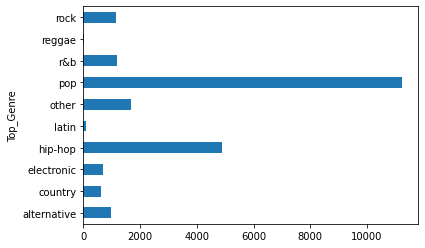

In [829]:
full_df.groupby("Top_Genre").count().Song.plot(kind="barh", use_index=True)

In [830]:
full_df.head()

,Song,Performer,Week Position,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID,Week_No,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,timesignature,Top_Genre
0,I'm Your Angel,R. Kelly & Celine Dion,1,1999-01-02,1.0,1.0,5.0,1.0,I'm Your AngelR. Kelly & Celine Dion,00,...,-7.260,1.0,0.0301,0.669,0.000000,0.110,0.266,112.681,4.0,other
1,Nobody's Supposed To Be Here,Deborah Cox,2,1999-01-02,2.0,2.0,14.0,1.0,Nobody's Supposed To Be HereDeborah Cox,00,...,-5.300,1.0,0.0361,0.202,0.000012,0.595,0.399,119.957,4.0,r&b
2,Lately,Divine,3,1999-01-02,3.0,1.0,17.0,1.0,LatelyDivine,00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hip-hop
3,...Baby One More Time,Britney Spears,4,1999-01-02,5.0,4.0,7.0,1.0,...Baby One More TimeBritney Spears,00,...,-5.745,0.0,0.0307,0.202,0.000131,0.443,0.907,92.960,4.0,pop
4,Because Of You,98 Degrees,5,1999-01-02,6.0,3.0,14.0,1.0,Because Of You98 Degrees,00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other


In [831]:
features_add.head()

,acousticness,album,artist,danceability,duration,energy,explicit,instrumentalness,liveness,loudness,mode,Song,popularity,speechiness,tempo,timesignature,valence,SongID
0,0.000728,Collective Soul (Deluxe Version),Collective Soul,0.520,234947,0.904,False,0.010300,0.0634,-5.030,1,Welcome All Again,35,0.0309,106.022,4,0.365,Welcome All AgainCollective Soul
1,0.018200,Collective Soul (Deluxe Version),Collective Soul,0.581,239573,0.709,False,0.000664,0.1740,-4.909,1,Fuzzy,31,0.0282,120.027,4,0.408,FuzzyCollective Soul
2,0.000473,Collective Soul (Deluxe Version),Collective Soul,0.572,198400,0.918,False,0.000431,0.0977,-3.324,0,Dig,30,0.0559,144.061,4,0.370,DigCollective Soul
3,0.000970,Collective Soul (Deluxe Version),Collective Soul,0.596,231453,0.661,False,0.000033,0.1130,-5.051,1,You,35,0.0254,111.975,4,0.183,YouCollective Soul
4,0.000036,Collective Soul (Deluxe Version),Collective Soul,0.520,222520,0.808,False,0.000010,0.0800,-4.553,0,My Days,21,0.0318,92.721,4,0.666,My DaysCollective Soul


In [832]:
master_song_list = pd.read_csv("../data/raw/archive/data.csv")

In [833]:
master_song_list.shape

(174389, 19)

In [834]:
full_df[full_df.liveness.isnull()].drop_duplicates(["Song", "Performer"])

,Song,Performer,Week Position,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID,Week_No,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,timesignature,Top_Genre
2,Lately,Divine,3,1999-01-02,3.0,1.0,17.0,1.0,LatelyDivine,00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hip-hop
4,Because Of You,98 Degrees,5,1999-01-02,6.0,3.0,14.0,1.0,Because Of You98 Degrees,00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
167,(God Must Have Spent) A Little More Time On You,'N Sync,8,1999-02-27,21.0,8.0,13.0,1.0,(God Must Have Spent) A Little More Time On Yo...,08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
199,It Ain't My Fault 1 & 2,Silkk The Shocker Featuring Mystikal,20,1999-03-06,NaN,20.0,1.0,1.0,It Ain't My Fault 1 & 2Silkk The Shocker Featu...,09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hip-hop
239,Hard Knock Life (Ghetto Anthem),JAY-Z,20,1999-03-20,NaN,20.0,17.0,2.0,Hard Knock Life (Ghetto Anthem)JAY-Z,11,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hip-hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20997,Rudolph The Red-Nosed Reindeer,Gene Autry,16,2019-01-05,28.0,16.0,4.0,1.0,Rudolph The Red-Nosed ReindeerGene Autry,00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,country
21968,Ran$om,Lil Tecca,19,2019-08-03,23.0,19.0,8.0,1.0,Ran$omLil Tecca,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hip-hop
22197,Saint-Tropez,Post Malone,18,2019-09-21,NaN,18.0,1.0,1.0,Saint-TropezPost Malone,37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hip-hop
22220,Don't Call Me Angel (Charlie's Angels),"Ariana Grande, Miley Cyrus & Lana Del Rey",13,2019-09-28,NaN,13.0,1.0,1.0,Don't Call Me Angel (Charlie's Angels)Ariana G...,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,pop


In [835]:
master_song_list.head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920


In [836]:
filled_nulls_1 = charters_with_avaiable_attributes.drop_duplicates(["name", "artist"])

In [837]:
remaining_songs = full_df[full_df.liveness.isnull()].drop_duplicates(["Song", "Performer"])[~(full_df[full_df.liveness.isnull()].drop_duplicates(["Song", "Performer"])\
                                                                            .SongID.map(tuple).isin(list(filled_nulls_1.SongID.map(tuple))))]

In [838]:
remaining_songs.sort_values("Performer", inplace=True)

In [844]:
remaining_songs.loc[:, ["Performer", "Song"]].reset_index(drop=True).iloc[:10, :]

,Performer,Song
0,'N Sync,(God Must Have Spent) A Little More Time On You
1,'N Sync,Gone
2,'N Sync,Pop
3,'N Sync,This I Promise You
4,'N Sync,Bye Bye Bye
5,'N Sync,It's Gonna Be Me
6,'N Sync & Gloria Estefan,Music Of My Heart
7,'N Sync Featuring Nelly,Girlfriend
8,98 Degrees,Because Of You
9,98 Degrees,The Hardest Thing


In [845]:
master_song_list[master_song_list.artists.str.contains("NSYNC")].sort_values("name")#.iloc[43:70, :]

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
53652,0.441000,['*NSYNC'],0.600,282960,0.544,0,4mljNnZ2eaXKSbEAOzLlLE,0.000000,10,0.2550,-8.863,1,(God Must Have Spent) A Little More Time On You,44,1997-05-26,0.0358,83.992,0.320,1997
107334,0.440000,['*NSYNC'],0.468,243493,0.535,0,72otaqywVqwyXaCjk75JKm,0.000000,10,0.1010,-8.264,1,(God Must Have Spent) A Little More Time On Yo...,56,2005-10-25,0.0436,168.001,0.294,2005
154475,0.435000,['*NSYNC'],0.587,241507,0.527,0,71iJTGlwQaHQTIYflaQxoM,0.000000,10,0.3020,-8.354,1,(God Must Have Spent) A Little More Time On Yo...,33,1998-11-13,0.0339,84.021,0.301,1998
89295,0.449000,['*NSYNC'],0.375,241493,0.527,0,08zfRiERqpy7J0x8akk7zt,0.000000,10,0.3050,-8.422,1,(God Must Have Spent) A Little More Time On Yo...,51,1997,0.0507,167.242,0.303,1997
35064,0.132000,['*NSYNC'],0.587,225493,0.837,0,42ahZK39o2uryeHVJbjqc0,0.000150,7,0.4070,-5.645,1,All I Want Is You (This Christmas),46,1998-10-30,0.0258,95.016,0.545,1998
15789,0.000479,"['Blaque', '*NSYNC']",0.695,218187,0.579,0,1cjBan0t4eBk2Y5j17hdyf,0.000000,0,0.0556,-5.066,1,Bring It All to Me (feat. *NSYNC),56,1999-05-28,0.0325,88.957,0.726,1999
15878,0.031000,['*NSYNC'],0.610,200400,0.926,0,62bOmKYxYg7dhrC6gH9vFn,0.001200,8,0.0821,-4.843,0,Bye Bye Bye,70,2000-03-21,0.0479,172.638,0.861,2000
105876,0.001840,['*NSYNC'],0.733,221667,0.876,0,612bpswbcCmHEudXJ9EHOK,0.000021,9,0.3210,-5.755,1,Crazy For You,37,1997-05-26,0.0326,115.901,0.877,1997
170137,0.012500,['*NSYNC'],0.643,263200,0.975,0,0yX0Zw8ouA5lD7rbzWfowL,0.000059,7,0.1350,-4.134,1,Digital Get Down,39,2000-03-21,0.1090,177.808,0.865,2000
122064,0.038500,['*NSYNC'],0.594,226200,0.653,0,5gvSsnnKJQYt16VhWqOeeQ,0.000000,2,0.0480,-5.447,0,For The Girl Who Has Everything - Club Mix,36,1997-05-26,0.0307,170.212,0.580,1997


In [846]:
master_song_list[master_song_list.name.str.contains("Roll Out")].sort_values("name").iloc[:25, :]

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
68232,0.151,['Rose Tattoo'],0.533,201200,0.772,0,2Ng8rpzfNPWHxCy91598wE,0.4680,4,0.270,-11.588,1,Rock 'N' Roll Outlaw,44,1978,0.0312,93.057,0.617,1978
137969,0.268,['Clutch'],0.416,179400,0.861,0,4t9K7T9zZd4GcKMv6H0TqL,0.0821,9,0.173,-7.502,1,Rock N Roll Outlaw,36,1995-04-18,0.1180,135.316,0.630,1995


In [847]:
remaining_songs.head()

,Song,Performer,Week Position,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID,Week_No,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,timesignature,Top_Genre
167,(God Must Have Spent) A Little More Time On You,'N Sync,8,1999-02-27,21.0,8.0,13.0,1.0,(God Must Have Spent) A Little More Time On Yo...,08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
2999,Gone,'N Sync,20,2001-11-10,27.0,20.0,8.0,1.0,Gone'N Sync,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
2578,Pop,'N Sync,19,2001-06-16,23.0,19.0,3.0,1.0,Pop'N Sync,23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
1878,This I Promise You,'N Sync,19,2000-10-14,31.0,19.0,3.0,1.0,This I Promise You'N Sync,41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other
1159,Bye Bye Bye,'N Sync,20,2000-02-05,42.0,20.0,2.0,1.0,Bye Bye Bye'N Sync,05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,other


In [848]:
associated_indexs = pd.Series([53652,
          54628,
          54486,
          15968,
          15878,
          15930,
          np.nan,
          np.nan,
          72232,
          35000,
          15574,
          np.nan,
          54323,
          18514,
          np.nan,
          np.nan,
          np.nan,
          125603,
          19748,
          18810,
          np.nan,
          171321,
          38088,
          18908,
          np.nan,
          56450,
          37972,
          56182,
          16310,
          16339,
          38832,
          np.nan,
          37334,
          np.nan,
          np.nan,
          np.nan,
          38488,
          19708,
          np.nan,
          16244,
          np.nan,
          np.nan,
          126223,
          np.nan,
          np.nan,
          36099,
          157977,
          np.nan,
          np.nan,
          173313,
          54874,
          19012,
          np.nan,
          91630,
          57882,
          17020,
          157905,
          57175,
          73080,
          39006,
          72866,
          np.nan,
          16028,
          15521,
          90416,
          np.nan,
          172705,
          18076,
          37464,
          171703,
          17684,
          37036,
          16380,
          np.nan,
          17730,
          16743,
          17908,
          36442,
          19146,
          np.nan,
          55538,
          17964,
          np.nan,
          37256,
          17878,
          18320,
          56324,
          138801,
          57770,
          170037,
          17156,
          19762,
          32432,
          17946,
          173655,
          np.nan,
          19356,
           16250,
           35784,
           57646,
          92416,
          38506,
          np.nan,
           142619,
           18286,
           17754,
           16162,
           90086,
           16298,
           35693,
           34953,
          15892,
          18578,
          37424,
          16409,
          36410,
          np.nan,
          58094,
          19486,
          np.nan,
          19576,
          54118,
          55708,
          109200,
          np.nan,
          19022,
          56284,
          92464,
          11046,
          38730,
          72153,
          17304,
          55856,
          75802,
          126103,
          19574,
          16066,
          np.nan,
          54954,
          16668,
          55874,
          19262,
          55502,
          16938,
          107598,
          36572,
          19206,
          125943])

In [849]:
remaining_songs = remaining_songs.reset_index(drop=True)

In [850]:
remaining_songs = pd.concat([remaining_songs, associated_indexs], axis=1)

In [851]:
remaining_songs.rename(columns={0: "merge_col"}, inplace=True)

In [852]:
remaining_songs = remaining_songs.drop(['explicit', 'duration',
       'popularity', 'danceability', 'energy', 'key', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'timesignature'], axis=1)

In [853]:
missing_songs_df = pd.merge(remaining_songs, master_song_list, "left", left_on="merge_col", right_index=True)

In [854]:
missing_songs_df.columns

Index(['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'id_x', 'album', 'Top_Genre',
       'merge_col', 'acousticness', 'artists', 'danceability', 'duration_ms',
       'energy', 'explicit', 'id_y', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'name', 'popularity', 'release_date', 'speechiness',
       'tempo', 'valence', 'year'],
      dtype='object')

In [855]:
full_df.columns

Index(['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'id', 'album', 'explicit',
       'duration', 'popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'timesignature', 'Top_Genre'],
      dtype='object')

In [865]:
missing_songs_df.loc[:12, "album"]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
5     NaN
6     NaN
7     NaN
8     NaN
9     NaN
10    NaN
11    NaN
12    NaN
Name: album, dtype: object

In [867]:
# Different Columns
[x for x in missing_songs_df.columns if x not in full_df.columns]

['duration_ms', 'id_y', 'release_date', 'year']

In [866]:
missing_songs_df.drop(["merge_col", "artists", "name", "id_x", "album"], axis=1, inplace=True)

In [868]:
missing_songs_df.rename(columns={"duration_ms": "duration", "id_y": "id"}, inplace=True)

In [869]:
missing_songs_df.explicit = missing_songs_df.explicit.apply(bool)

In [870]:
missing_songs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148 entries, 0 to 147
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Song                    148 non-null    object        
 1   Performer               148 non-null    object        
 2   Week Position           148 non-null    int64         
 3   WeekID                  148 non-null    datetime64[ns]
 4   Previous Week Position  94 non-null     float64       
 5   Peak Position           148 non-null    float64       
 6   Weeks on Chart          148 non-null    float64       
 7   Instance                148 non-null    float64       
 8   SongID                  148 non-null    object        
 9   Week_No                 148 non-null    object        
 10  spotify_genre           98 non-null     object        
 11  Top_Genre               148 non-null    object        
 12  acousticness            117 non-null    float64   

In [675]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22597 entries, 0 to 22596
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Song                    22597 non-null  object        
 1   Performer               22597 non-null  object        
 2   Week Position           22597 non-null  int64         
 3   WeekID                  22597 non-null  datetime64[ns]
 4   Previous Week Position  22125 non-null  float64       
 5   Peak Position           22597 non-null  float64       
 6   Weeks on Chart          22597 non-null  float64       
 7   Instance                22597 non-null  float64       
 8   SongID                  22597 non-null  object        
 9   Week_No                 22597 non-null  object        
 10  spotify_genre           21750 non-null  object        
 11  album                   20814 non-null  object        
 12  explicit                20814 non-null  object

In [872]:
missing_songs_df[missing_songs_df.energy.isnull()]

,Song,Performer,Week Position,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID,Week_No,...,key,liveness,loudness,mode,popularity,release_date,speechiness,tempo,valence,year
6,Music Of My Heart,'N Sync & Gloria Estefan,2,1999-10-16,41.0,2.0,7.0,1.0,Music Of My Heart'N Sync & Gloria Estefan,41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Girlfriend,'N Sync Featuring Nelly,18,2002-03-09,22.0,18.0,5.0,1.0,Girlfriend'N Sync Featuring Nelly,09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,Give Me Just One Night (Una Noche),98 Degrees,19,2000-09-23,26.0,19.0,6.0,1.0,Give Me Just One Night (Una Noche)98 Degrees,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,I Care 4 U,Aaliyah,19,2002-09-28,22.0,19.0,6.0,1.0,I Care 4 UAaliyah,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,God Bless The U.S.A.,American Idol Finalists,4,2003-05-03,NaN,4.0,1.0,1.0,God Bless The U.S.A.American Idol Finalists,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,If I Could Go!,Angie Martinez Featuring Lil' Mo & Sacario,20,2002-09-14,25.0,20.0,13.0,1.0,If I Could Go!Angie Martinez Featuring Lil' Mo...,36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,Don't Call Me Angel (Charlie's Angels),"Ariana Grande, Miley Cyrus & Lana Del Rey",13,2019-09-28,NaN,13.0,1.0,1.0,Don't Call Me Angel (Charlie's Angels)Ariana G...,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,You Give Love A Bad Name,Blake Lewis,18,2007-06-09,NaN,18.0,1.0,1.0,You Give Love A Bad NameBlake Lewis,22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,I'll Stand By You,Carrie Underwood,6,2007-05-12,NaN,6.0,1.0,1.0,I'll Stand By YouCarrie Underwood,18,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,The Christmas Song (Chestnuts Roasting On An O...,Christina Aguilera,18,2000-01-01,47.0,18.0,3.0,1.0,The Christmas Song (Chestnuts Roasting On An O...,00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [933]:
missing_songs = {7: [{
  "danceability": 0.748,
  "energy": 0.811,
  "key": 0,
  "loudness": -5.213,
  "mode": 0,
  "speechiness": 0.0907,
  "acousticness": 0.0866,
  "instrumentalness": 0.0000145,
  "liveness": 0.0282,
  "valence": 0.862,
  "tempo": 93.963,
  "type": "audio_features",
  "id": "6u5flhVFxKZrl9AApvf2SL",
  "uri": "spotify:track:6u5flhVFxKZrl9AApvf2SL",
  "track_href": "https://api.spotify.com/v1/tracks/6u5flhVFxKZrl9AApvf2SL",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/6u5flhVFxKZrl9AApvf2SL",
  "duration_ms": 253600,
  "time_signature": 4,
    "explicit": False,
    "release_date": "2001-07-24",
    "popularity": 47
    
}],
6: [{
  "danceability": 0.375,
  "energy": 0.556,
  "key": 11,
  "loudness": -7.201,
  "mode": 1,
  "speechiness": 0.0411,
  "acousticness": 0.398,
  "instrumentalness": 0,
  "liveness": 0.0956,
  "valence": 0.398,
  "tempo": 111.824,
  "type": "audio_features",
  "id": "0M3ZIWNcizkhYFvn6RuCEz",
  "uri": "spotify:track:0M3ZIWNcizkhYFvn6RuCEz",
  "track_href": "https://api.spotify.com/v1/tracks/0M3ZIWNcizkhYFvn6RuCEz",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/0M3ZIWNcizkhYFvn6RuCEz",
  "duration_ms": 271160,
  "time_signature": 4,
    "explicit": False,
    "release_date": "1999-09-28",
    "popularity": 41
}],
11: [{
  "danceability": 0.543,
  "energy": 0.79,
  "key": 0,
  "loudness": -6.145,
  "mode": 1,
  "speechiness": 0.0491,
  "acousticness": 0.0513,
  "instrumentalness": 0.00000355,
  "liveness": 0.0981,
  "valence": 0.655,
  "tempo": 123.631,
  "type": "audio_features",
  "id": "1OvjOVieEsYqGiK1T3mUv9",
  "uri": "spotify:track:1OvjOVieEsYqGiK1T3mUv9",
  "track_href": "https://api.spotify.com/v1/tracks/1OvjOVieEsYqGiK1T3mUv9",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/1OvjOVieEsYqGiK1T3mUv9",
  "duration_ms": 205160,
  "time_signature": 4,
    "explicit": False,
    "release_date": "2000-09-26",
    "popularity": 42
}],
20: [{
  "danceability": 0.644,
  "energy": 0.755,
  "key": 1,
  "loudness": -5.325,
  "mode": 1,
  "speechiness": 0.0448,
  "acousticness": 0.00237,
  "instrumentalness": 0.00000764,
  "liveness": 0.0859,
  "valence": 0.334,
  "tempo": 102.861,
  "type": "audio_features",
  "id": "6zegtH6XXd2PDPLvy1Y0n2",
  "uri": "spotify:track:6zegtH6XXd2PDPLvy1Y0n2",
  "track_href": "https://api.spotify.com/v1/tracks/6zegtH6XXd2PDPLvy1Y0n2",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/6zegtH6XXd2PDPLvy1Y0n2",
  "duration_ms": 190067,
  "time_signature": 4,
    "explicit": False,
    "release_date": "2019-11-01",
    "popularity": 72
}],
34: [{
  "danceability": 0.267,
  "energy": 0.619,
  "key": 9,
  "loudness": -5.392,
  "mode": 1,
  "speechiness": 0.0298,
  "acousticness": 0.324,
  "instrumentalness": 0.00000117,
  "liveness": 0.148,
  "valence": 0.185,
  "tempo": 146.1,
  "type": "audio_features",
  "id": "4nl0AClM6HOOKwHJwLezEK",
  "uri": "spotify:track:4nl0AClM6HOOKwHJwLezEK",
  "track_href": "https://api.spotify.com/v1/tracks/4nl0AClM6HOOKwHJwLezEK",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/4nl0AClM6HOOKwHJwLezEK",
  "duration_ms": 327827,
  "time_signature": 4,
    "explicit": False,
    "release_date": "2003-08-15",
    "popularity": 19
}],
43: [{
  "danceability": 0.822,
  "energy": 0.318,
  "key": 10,
  "loudness": -12.391,
  "mode": 1,
  "speechiness": 0.0575,
  "acousticness": 0.493,
  "instrumentalness": 0.0128,
  "liveness": 0.11,
  "valence": 0.138,
  "tempo": 102.998,
  "type": "audio_features",
  "id": "6G8kHiVZ1jW7vHMPVRNZU0",
  "uri": "spotify:track:6G8kHiVZ1jW7vHMPVRNZU0",
  "track_href": "https://api.spotify.com/v1/tracks/6G8kHiVZ1jW7vHMPVRNZU0",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/6G8kHiVZ1jW7vHMPVRNZU0",
  "duration_ms": 245787,
  "time_signature": 4,
    "explicit": False,
    "release_date": "2018-06-29",
    "popularity": 70
}],
61: [{
  "danceability": 0.431,
  "energy": 0.957,
  "key": 10,
  "loudness": -0.982,
  "mode": 0,
  "speechiness": 0.26,
  "acousticness": 0.0261,
  "instrumentalness": 0,
  "liveness": 0.261,
  "valence": 0.419,
  "tempo": 105.468,
  "type": "audio_features",
  "id": "1SlPhbS52PbNqqVCqGU12I",
  "uri": "spotify:track:1SlPhbS52PbNqqVCqGU12I",
  "track_href": "https://api.spotify.com/v1/tracks/1SlPhbS52PbNqqVCqGU12I",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/1SlPhbS52PbNqqVCqGU12I",
  "duration_ms": 223120,
  "time_signature": 4,
    "explicit": True,
    "release_date": "2006-11-21",
    "popularity": 37
}],
48: [{
  "danceability": 0.662,
  "energy": 0.942,
  "key": 3,
  "loudness": -3.631,
  "mode": 0,
  "speechiness": 0.072,
  "acousticness": 0.00854,
  "instrumentalness": 0,
  "liveness": 0.117,
  "valence": 0.787,
  "tempo": 133.03,
  "type": "audio_features",
  "id": "1XS0Gyb2YyUgoxa8O67emr",
  "uri": "spotify:track:1XS0Gyb2YyUgoxa8O67emr",
  "track_href": "https://api.spotify.com/v1/tracks/1XS0Gyb2YyUgoxa8O67emr",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/1XS0Gyb2YyUgoxa8O67emr",
  "duration_ms": 214760,
  "time_signature": 4,
    "explicit": False,
    "release_date": "2010-01-01",
    "popularity": 48
}],
65: [{
  "danceability": 0.596,
  "energy": 0.661,
  "key": 5,
  "loudness": -6.239,
  "mode": 0,
  "speechiness": 0.226,
  "acousticness": 0.31,
  "instrumentalness": 0,
  "liveness": 0.0847,
  "valence": 0.86,
  "tempo": 129.491,
  "type": "audio_features",
  "id": "5mNV8Mz59bzyuQ53gTw0c0",
  "uri": "spotify:track:5mNV8Mz59bzyuQ53gTw0c0",
  "track_href": "https://api.spotify.com/v1/tracks/5mNV8Mz59bzyuQ53gTw0c0",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/5mNV8Mz59bzyuQ53gTw0c0",
  "duration_ms": 232573,
  "time_signature": 5,
    "explicit": False,
    "release_date": "2001-07-03",
    "popularity": 64
}],
82: [{
  "danceability": 0.562,
  "energy": 0.8,
  "key": 0,
  "loudness": -5.404,
  "mode": 1,
  "speechiness": 0.112,
  "acousticness": 0.0814,
  "instrumentalness": 0,
  "liveness": 0.199,
  "valence": 0.471,
  "tempo": 95.029,
  "type": "audio_features",
  "id": "7qvxFz3JodM0A7xEM7k3YD",
  "uri": "spotify:track:7qvxFz3JodM0A7xEM7k3YD",
  "track_href": "https://api.spotify.com/v1/tracks/7qvxFz3JodM0A7xEM7k3YD",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/7qvxFz3JodM0A7xEM7k3YD",
  "duration_ms": 237733,
  "time_signature": 4,
    "explicit": False,
    "release_date": "2017-06-09",
    "popularity": 68
}],
95: [{
  "danceability": 0.768,
  "energy": 0.541,
  "key": 6,
  "loudness": -5.183,
  "mode": 0,
  "speechiness": 0.1,
  "acousticness": 0.286,
  "instrumentalness": 0,
  "liveness": 0.107,
  "valence": 0.645,
  "tempo": 95.715,
  "type": "audio_features",
  "id": "6KCOOKsDFfGEiwWZZlEI6O",
  "uri": "spotify:track:6KCOOKsDFfGEiwWZZlEI6O",
  "track_href": "https://api.spotify.com/v1/tracks/6KCOOKsDFfGEiwWZZlEI6O",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/6KCOOKsDFfGEiwWZZlEI6O",
  "duration_ms": 265588,
  "time_signature": 4,
    "explicit": False,
    "release_date": "2001-09-15",
    "popularity": 34
}],
102: [{
  "danceability": 0.721,
  "energy": 0.79,
  "key": 1,
  "loudness": -4.125,
  "mode": 1,
  "speechiness": 0.124,
  "acousticness": 0.183,
  "instrumentalness": 0,
  "liveness": 0.1,
  "valence": 0.821,
  "tempo": 103.141,
  "type": "audio_features",
  "id": "75b9JVzc4QFvPBO7jDRIVe",
  "uri": "spotify:track:75b9JVzc4QFvPBO7jDRIVe",
  "track_href": "https://api.spotify.com/v1/tracks/75b9JVzc4QFvPBO7jDRIVe",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/75b9JVzc4QFvPBO7jDRIVe",
  "duration_ms": 229173,
  "time_signature": 4,
    "explicit": False,
    "release_date": "2001-09-11",
    "popularity": 40
}],
116: [{
  "danceability": 0.861,
  "energy": 0.742,
  "key": 3,
  "loudness": -3.292,
  "mode": 0,
  "speechiness": 0.148,
  "acousticness": 0.0035,
  "instrumentalness": 0,
  "liveness": 0.0643,
  "valence": 0.655,
  "tempo": 126.01,
  "type": "audio_features",
  "id": "26spalP6x2gUAab8rwB8dQ",
  "uri": "spotify:track:26spalP6x2gUAab8rwB8dQ",
  "track_href": "https://api.spotify.com/v1/tracks/26spalP6x2gUAab8rwB8dQ",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/26spalP6x2gUAab8rwB8dQ",
  "duration_ms": 194960,
  "time_signature": 4,
    "explicit": False,
    "release_date": "2013-04-12",
    "popularity": 58
}],
119: [{
  "danceability": 0.585,
  "energy": 0.52,
  "key": 5,
  "loudness": -6.136,
  "mode": 0,
  "speechiness": 0.0712,
  "acousticness": 0.124,
  "instrumentalness": 0.0000701,
  "liveness": 0.131,
  "valence": 0.129,
  "tempo": 159.801,
  "type": "audio_features",
  "id": "0e7ipj03S05BNilyu5bRzt",
  "uri": "spotify:track:0e7ipj03S05BNilyu5bRzt",
  "track_href": "https://api.spotify.com/v1/tracks/0e7ipj03S05BNilyu5bRzt",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/0e7ipj03S05BNilyu5bRzt",
  "duration_ms": 218147,
  "time_signature": 4,
    "explicit": True,
    "release_date": "2018-04-27",
    "popularity": 83 
}],
124: [{
  "danceability": 0.635,
  "energy": 0.854,
  "key": 10,
  "loudness": -5.02,
  "mode": 0,
  "speechiness": 0.0612,
  "acousticness": 0.00579,
    "instrumentalness": 0.0,
  "liveness": 0.0623,
  "valence": 0.59,
  "tempo": 100.851,
  "type": "audio_features",
  "id": "45cVyfWuMAg8RNxmkcpmy9",
  "uri": "spotify:track:45cVyfWuMAg8RNxmkcpmy9",
  "track_href": "https://api.spotify.com/v1/tracks/45cVyfWuMAg8RNxmkcpmy9",
  "analysis_url": "https://api.spotify.com/v1/audio-analysis/45cVyfWuMAg8RNxmkcpmy9",
  "duration_ms": 252707,
  "time_signature": 4,
    "explicit": False,
    "release_date": "2008-01-01",
    "popularity": 52
}]}

In [877]:
!git status

On branch master
Your branch is ahead of 'origin/master' by 3 commits.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   ../.gitignore

no changes added to commit (use "git add" and/or "git commit -a")


In [875]:
!git add ../.gitignore

In [878]:
!git commit -m "Notebook Checkpoint 2" -m "Before Recombining All The Data and Exporting It."

On branch master
Your branch is ahead of 'origin/master' by 3 commits.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   ../.gitignore

no changes added to commit (use "git add" and/or "git commit -a")


## Recombining All Data

In [934]:
keys = list(missing_songs.keys())

In [935]:
new_dict = {"index": []}
for i, dic in missing_songs.items():
    keys = list(dic[0].keys())
    new_dict["index"].append(i)
    for k in keys:
        if k not in new_dict.keys():
            new_dict[k] = []
        new_dict[k].append(dic[0][k])

In [937]:
last_of_the_missing_songs = pd.DataFrame.from_dict(new_dict).set_index("index")

In [938]:
stragalers = missing_songs_df[missing_songs_df.energy.isnull()]

In [939]:
stragalers = stagalers.iloc[:, :11]

In [940]:
final_unallocated = pd.merge(stragalers, last_of_the_missing_songs, "left", left_index=True, right_index=True)

In [941]:
full_df.columns

Index(['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'id', 'album', 'explicit',
       'duration', 'popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'timesignature', 'Top_Genre'],
      dtype='object')

In [942]:
final_unallocated.columns

Index(['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature', 'explicit',
       'release_date', 'popularity'],
      dtype='object')

In [943]:
[x for x in final_unallocated.columns if x not in full_df.columns]

['type',
 'uri',
 'track_href',
 'analysis_url',
 'duration_ms',
 'time_signature',
 'release_date']

In [944]:
final_unallocated.drop(["type", "uri", "track_href", "analysis_url"], axis=1, inplace=True)

In [945]:
final_unallocated = final_unallocated.rename(columns={"time_signature": "timesignature",
                                 "duration_ms": "duration"})

In [946]:
[x for x in final_unallocated.columns if x not in full_df.columns]

['release_date']

In [947]:
missing_songs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 0 to 147
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Song                    117 non-null    object        
 1   Performer               117 non-null    object        
 2   Week Position           117 non-null    int64         
 3   WeekID                  117 non-null    datetime64[ns]
 4   Previous Week Position  78 non-null     float64       
 5   Peak Position           117 non-null    float64       
 6   Weeks on Chart          117 non-null    float64       
 7   Instance                117 non-null    float64       
 8   SongID                  117 non-null    object        
 9   Week_No                 117 non-null    object        
 10  spotify_genre           74 non-null     object        
 11  Top_Genre               117 non-null    object        
 12  acousticness            117 non-null    float64   

In [948]:
final_unallocated.iloc[:5, :15]

,Song,Performer,Week Position,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID,Week_No,spotify_genre,danceability,energy,key,loudness
6,Music Of My Heart,'N Sync & Gloria Estefan,2,1999-10-16,41.0,2.0,7.0,1.0,Music Of My Heart'N Sync & Gloria Estefan,41,[],0.375,0.556,11.0,-7.201
7,Girlfriend,'N Sync Featuring Nelly,18,2002-03-09,22.0,18.0,5.0,1.0,Girlfriend'N Sync Featuring Nelly,09,[],0.748,0.811,0.0,-5.213
11,Give Me Just One Night (Una Noche),98 Degrees,19,2000-09-23,26.0,19.0,6.0,1.0,Give Me Just One Night (Una Noche)98 Degrees,38,[],0.543,0.790,0.0,-6.145
14,I Care 4 U,Aaliyah,19,2002-09-28,22.0,19.0,6.0,1.0,I Care 4 UAaliyah,38,"['dance pop', 'hip hop', 'hip pop', 'pop', 'po...",NaN,NaN,NaN,NaN
15,God Bless The U.S.A.,American Idol Finalists,4,2003-05-03,NaN,4.0,1.0,1.0,God Bless The U.S.A.American Idol Finalists,17,['idol'],NaN,NaN,NaN,NaN


In [949]:
[x for x in missing_songs_df if x not in final_unallocated.columns]

['Top_Genre', 'year']

In [950]:
missing_songs_df.shape

(117, 29)

In [951]:
final_unallocated.shape

(31, 28)

In [960]:
final_unallocated.loc[:, "Top_Genre"] = final_unallocated.spotify_genre.apply(genreGuess)

In [966]:
final_unallocated.year = final_unallocated.WeekID.apply(dt.datetime.strftime, format="%Y")

C:\Users\Kyle\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [975]:
missing_songs_df.columns

Index(['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'Top_Genre', 'acousticness',
       'danceability', 'duration', 'energy', 'explicit', 'id',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'release_date', 'speechiness', 'tempo', 'valence', 'year'],
      dtype='object')

In [973]:
missings_songs_full = pd.concat([missing_songs_df, final_unallocated], axis=0)

In [974]:
missings_songs_full

,Song,Performer,Week Position,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID,Week_No,...,liveness,loudness,mode,popularity,release_date,speechiness,tempo,valence,year,timesignature
0,(God Must Have Spent) A Little More Time On You,'N Sync,8,1999-02-27,21.0,8.0,13.0,1.0,(God Must Have Spent) A Little More Time On Yo...,08,...,0.2550,-8.863,1.0,44.0,1997-05-26,0.0358,83.992,0.320,1997.0,NaN
1,Gone,'N Sync,20,2001-11-10,27.0,20.0,8.0,1.0,Gone'N Sync,44,...,0.1090,-8.581,0.0,52.0,2001-07-24,0.0597,113.863,0.495,2001.0,NaN
2,Pop,'N Sync,19,2001-06-16,23.0,19.0,3.0,1.0,Pop'N Sync,23,...,0.1270,-6.684,1.0,55.0,2001-07-24,0.1540,119.946,0.923,2001.0,NaN
3,This I Promise You,'N Sync,19,2000-10-14,31.0,19.0,3.0,1.0,This I Promise You'N Sync,41,...,0.1280,-6.279,1.0,68.0,2000-03-21,0.0329,165.975,0.466,2000.0,NaN
4,Bye Bye Bye,'N Sync,20,2000-02-05,42.0,20.0,2.0,1.0,Bye Bye Bye'N Sync,05,...,0.0821,-4.843,0.0,70.0,2000-03-21,0.0479,172.638,0.861,2000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,Loverboy,Mariah Carey Featuring Cameo,2,2001-08-04,60.0,2.0,7.0,1.0,LoverboyMariah Carey Featuring Cameo,30,...,0.1000,-4.125,1.0,40.0,2001-09-11,0.1240,103.141,0.821,NaN,4.0
116,Gentleman,PSY,12,2013-04-27,NaN,12.0,1.0,1.0,GentlemanPSY,16,...,0.0643,-3.292,0.0,58.0,2013-04-12,0.1480,126.010,0.655,NaN,4.0
119,Rockstar,Post Malone Featuring 21 Savage,2,2017-10-07,NaN,2.0,1.0,1.0,RockstarPost Malone Featuring 21 Savage,40,...,0.1310,-6.136,0.0,83.0,2018-04-27,0.0712,159.801,0.129,NaN,4.0
124,Nobody Wants To Be Lonely,Ricky Martin Duet With Christina Aguilera,16,2001-02-17,26.0,16.0,4.0,1.0,Nobody Wants To Be LonelyRicky Martin Duet Wit...,06,...,0.0623,-5.020,0.0,52.0,2008-01-01,0.0612,100.851,0.590,NaN,4.0


In [982]:
fill_ins = full_df[full_df.liveness.isnull()]

In [987]:
fill_ins = fill_ins.iloc[:, :11]

In [993]:
missings_songs_full = missings_songs_full.loc[:, ['SongID', 'Top_Genre', 'acousticness',
       'danceability', 'duration', 'energy', 'explicit', 'id',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'release_date', 'speechiness', 'tempo', 'valence', 'year',
       'timesignature',  'Top_Genre']]

In [997]:
fill_ins_full = pd.merge(fill_ins, missings_songs_full, "left", on=["SongID"])

In [1013]:
[x for x in fill_ins_full.columns if x not in full_df.columns]

['release_date', 'year']

In [1009]:
fill_ins_full.loc[:, "album"] = ""

In [1031]:
fill_ins_full.columns

Index(['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'Top_Genre', 'acousticness',
       'danceability', 'duration', 'energy', 'explicit', 'id',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'release_date', 'speechiness', 'tempo', 'valence', 'year',
       'timesignature', 'Top_Genre', 'album'],
      dtype='object')

In [1012]:
fill_ins_full.loc[:, ['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'id', 'album', 'explicit',
       'duration', 'popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'timesignature', 'Top_Genre']]

,Song,Performer,Week Position,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID,Week_No,...,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,timesignature,Top_Genre,Top_Genre
0,Lately,Divine,3,1999-01-02,3.0,1.0,17.0,1.0,LatelyDivine,00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hip-hop,hip-hop
1,Because Of You,98 Degrees,5,1999-01-02,6.0,3.0,14.0,1.0,Because Of You98 Degrees,00,...,1.0,0.0271,0.341,0.0,0.113,0.514,104.498,NaN,other,other
2,Lately,Divine,5,1999-01-09,3.0,1.0,18.0,1.0,LatelyDivine,01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hip-hop,hip-hop
3,Because Of You,98 Degrees,6,1999-01-09,5.0,3.0,15.0,1.0,Because Of You98 Degrees,01,...,1.0,0.0271,0.341,0.0,0.113,0.514,104.498,NaN,other,other
4,Lately,Divine,5,1999-01-16,5.0,1.0,19.0,1.0,LatelyDivine,02,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,hip-hop,hip-hop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1860,"10,000 Hours",Dan + Shay & Justin Bieber,9,2019-11-30,10.0,4.0,7.0,1.0,"10,000 HoursDan + Shay & Justin Bieber",47,...,1.0,0.0259,0.153,0.0,0.111,0.430,89.991,NaN,country,country
1861,"10,000 Hours",Dan + Shay & Justin Bieber,8,2019-12-07,9.0,4.0,8.0,1.0,"10,000 HoursDan + Shay & Justin Bieber",48,...,1.0,0.0259,0.153,0.0,0.111,0.430,89.991,NaN,country,country
1862,"10,000 Hours",Dan + Shay & Justin Bieber,10,2019-12-14,8.0,4.0,9.0,1.0,"10,000 HoursDan + Shay & Justin Bieber",49,...,1.0,0.0259,0.153,0.0,0.111,0.430,89.991,NaN,country,country
1863,"10,000 Hours",Dan + Shay & Justin Bieber,14,2019-12-21,10.0,4.0,10.0,1.0,"10,000 HoursDan + Shay & Justin Bieber",50,...,1.0,0.0259,0.153,0.0,0.111,0.430,89.991,NaN,country,country


In [1017]:
full_without_nulls = full_df[~(full_df.liveness.isnull())]

In [1023]:
_before_merge = pd.merge(full_without_nulls, master_song_list.loc[:, ["id", "release_date", "year"]], "left", on=["id"])

In [1029]:
fill_ins_full.columns

Index(['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'Top_Genre', 'acousticness',
       'danceability', 'duration', 'energy', 'explicit', 'id',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'popularity',
       'release_date', 'speechiness', 'tempo', 'valence', 'year',
       'timesignature', 'Top_Genre', 'album'],
      dtype='object')

In [1030]:
_before_merge.columns

Index(['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'id', 'album', 'explicit',
       'duration', 'popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'timesignature', 'Top_Genre', 'release_date',
       'year'],
      dtype='object')

In [1032]:
fill_ins_full.shape

(1865, 32)

In [1033]:
_before_merge.shape

(20732, 31)

In [1039]:
_before_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20732 entries, 0 to 20731
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Song                    20732 non-null  object        
 1   Performer               20732 non-null  object        
 2   Week Position           20732 non-null  int64         
 3   WeekID                  20732 non-null  datetime64[ns]
 4   Previous Week Position  20331 non-null  float64       
 5   Peak Position           20732 non-null  float64       
 6   Weeks on Chart          20732 non-null  float64       
 7   Instance                20732 non-null  float64       
 8   SongID                  20732 non-null  object        
 9   Week_No                 20732 non-null  object        
 10  spotify_genre           20702 non-null  object        
 11  id                      20732 non-null  object        
 12  album                   20732 non-null  object

In [1047]:
fill_ins_full = fill_ins_full.loc[:, ['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'id', 'album', 'explicit',
       'duration', 'popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'timesignature', 'Top_Genre', 'release_date',
       'year']]

In [1049]:
for i, t in zip(fill_ins_full.columns, _before_merge.columns):
    print(i + " : " + t)

Song : Song
Performer : Performer
Week Position : Week Position
WeekID : WeekID
Previous Week Position : Previous Week Position
Peak Position : Peak Position
Weeks on Chart : Weeks on Chart
Instance : Instance
SongID : SongID
Week_No : Week_No
spotify_genre : spotify_genre
id : id
album : album
explicit : explicit
duration : duration
popularity : popularity
danceability : danceability
energy : energy
key : key
loudness : loudness
mode : mode
speechiness : speechiness
acousticness : acousticness
instrumentalness : instrumentalness
liveness : liveness
valence : valence
tempo : tempo
timesignature : timesignature
Top_Genre : Top_Genre
Top_Genre : release_date
release_date : year


In [1051]:
_before_merge.columns

Index(['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'id', 'album', 'explicit',
       'duration', 'popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'timesignature', 'Top_Genre', 'release_date',
       'year'],
      dtype='object')

In [1056]:
fill_ins_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1865 entries, 0 to 1864
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Song                    1865 non-null   object        
 1   Performer               1865 non-null   object        
 2   Week Position           1865 non-null   int64         
 3   WeekID                  1865 non-null   datetime64[ns]
 4   Previous Week Position  1794 non-null   float64       
 5   Peak Position           1865 non-null   float64       
 6   Weeks on Chart          1865 non-null   float64       
 7   Instance                1865 non-null   float64       
 8   SongID                  1865 non-null   object        
 9   Week_No                 1865 non-null   object        
 10  spotify_genre           1048 non-null   object        
 11  id                      1528 non-null   object        
 12  album                   1865 non-null   object  

In [1069]:
fif = pd.concat([fill_ins_full.iloc[:, :28], fill_ins_full.iloc[:, 29:]], axis=1)

In [1071]:
for i,r in zip(fif.columns, _before_merge.columns):
    print(i + " : " + r)

Song : Song
Performer : Performer
Week Position : Week Position
WeekID : WeekID
Previous Week Position : Previous Week Position
Peak Position : Peak Position
Weeks on Chart : Weeks on Chart
Instance : Instance
SongID : SongID
Week_No : Week_No
spotify_genre : spotify_genre
id : id
album : album
explicit : explicit
duration : duration
popularity : popularity
danceability : danceability
energy : energy
key : key
loudness : loudness
mode : mode
speechiness : speechiness
acousticness : acousticness
instrumentalness : instrumentalness
liveness : liveness
valence : valence
tempo : tempo
timesignature : timesignature
Top_Genre : Top_Genre
release_date : release_date
year : year


In [1099]:
final_df = pd.concat([_before_merge, fif], axis=0, ignore_index=True).sort_values(["WeekID", "Week Position"]).reset_index(drop=True)

In [1116]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21920 entries, 0 to 21919
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   Song                    21920 non-null  object        
 1   Performer               21920 non-null  object        
 2   Week Position           21920 non-null  int64         
 3   WeekID                  21920 non-null  datetime64[ns]
 4   Previous Week Position  21464 non-null  float64       
 5   Peak Position           21920 non-null  float64       
 6   Weeks on Chart          21920 non-null  float64       
 7   Instance                21920 non-null  float64       
 8   SongID                  21920 non-null  object        
 9   Week_No                 21920 non-null  object        
 10  spotify_genre           21073 non-null  object        
 11  id                      21584 non-null  object        
 12  album                   21920 non-null  object

In [1101]:
final_df.release_date = pd.to_datetime(final_df.release_date)

In [1102]:
final_df.shape

(22597, 31)

In [1103]:
final_df = final_df.drop_duplicates(subset=["Song", "Performer", "Week Position", "Weeks on Chart"])

In [1108]:
final_df.shape[0] == top20_df_orig.shape[0]

True

In [1109]:
final_df = final_df.reset_index(drop=True)

In [1113]:
final_df.explicit.fillna(False, inplace=True)

In [1114]:
final_df.explicit = final_df.explicit.apply(int)

In [1121]:
from sqlalchemy import create_engine

In [1124]:
engine = create_engine('sqlite:///../data/processed/musicData.db', echo=False)

In [1125]:
final_df.to_sql("billboard", con=engine)

In [1127]:
master_song_list

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
0,0.991000,['Mamie Smith'],0.598,168333,0.224,0,0cS0A1fUEUd1EW3FcF8AEI,0.000522,5,0.3790,-12.628,0,Keep A Song In Your Soul,12,1920,0.0936,149.976,0.6340,1920
1,0.643000,"[""Screamin' Jay Hawkins""]",0.852,150200,0.517,0,0hbkKFIJm7Z05H8Zl9w30f,0.026400,5,0.0809,-7.261,0,I Put A Spell On You,7,1920-01-05,0.0534,86.889,0.9500,1920
2,0.993000,['Mamie Smith'],0.647,163827,0.186,0,11m7laMUgmOKqI3oYzuhne,0.000018,0,0.5190,-12.098,1,Golfing Papa,4,1920,0.1740,97.600,0.6890,1920
3,0.000173,['Oscar Velazquez'],0.730,422087,0.798,0,19Lc5SfJJ5O1oaxY0fpwfh,0.801000,2,0.1280,-7.311,1,True House Music - Xavier Santos & Carlos Gomi...,17,1920-01-01,0.0425,127.997,0.0422,1920
4,0.295000,['Mixe'],0.704,165224,0.707,1,2hJjbsLCytGsnAHfdsLejp,0.000246,10,0.4020,-6.036,0,Xuniverxe,2,1920-10-01,0.0768,122.076,0.2990,1920
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
174384,0.009170,"['DJ Combo', 'Sander-7', 'Tony T']",0.792,147615,0.866,0,46LhBf6TvYjZU2SMvGZAbn,0.000060,6,0.1780,-5.089,0,The One,0,2020-12-25,0.0356,125.972,0.1860,2020
174385,0.795000,['Alessia Cara'],0.429,144720,0.211,0,7tue2Wemjd0FZzRtDrQFZd,0.000000,4,0.1960,-11.665,1,A Little More,0,2021-01-22,0.0360,94.710,0.2280,2021
174386,0.806000,['Roger Fly'],0.671,218147,0.589,0,48Qj61hOdYmUCFJbpQ29Ob,0.920000,4,0.1130,-12.393,0,Together,0,2020-12-09,0.0282,108.058,0.7140,2020
174387,0.920000,['Taylor Swift'],0.462,244000,0.240,1,1gcyHQpBQ1lfXGdhZmWrHP,0.000000,0,0.1130,-12.077,1,champagne problems,69,2021-01-07,0.0377,171.319,0.3200,2021


In [1130]:
master_song_list.release_date = pd.to_datetime(master_song_list.release_date)

In [1180]:
sample_songs = master_song_list[(master_song_list.release_date > dt.datetime(1999, 1, 1)) & (master_song_list.release_date < dt.datetime(2020, 1, 1))]

In [1152]:
billboard_ids = pd.merge(final_df.loc[:, ["Song", "SongID"]], attr_df, "left", on=["SongID"]).drop_duplicates(subset=["Song_x", "Performer"]).id.dropna().values

In [1161]:
bil_ids = fif.drop_duplicates(subset=["Song", "Performer"]).id.dropna()

In [1162]:
billboard_ids = list(billboard_ids)

In [1163]:
billboard_ids.extend(list(bil_ids))

In [1181]:
sample_songs.shape

(37564, 19)

In [1182]:
sample_song_table = sample_songs[~(sample_songs.id.isin(tuple(billboard_ids)))]

In [1183]:
sample_song_table.loc[:, "year"] = sample_song_table.release_date.apply(dt.datetime.strftime, format="%Y")

C:\Users\Kyle\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [1195]:
sample_song_table = sample_song_table.reset_index(drop=True)

In [1198]:
sample_song_table.to_sql("samples", con=engine, if_exists="replace")

# Wednesday's Code

In [90]:
import pandas as pd, numpy as np, datetime as dt, os
import operator, json
from sqlalchemy import create_engine

In [4]:
engine = create_engine('sqlite:///../data/processed/musicData.db', echo=False)

In [7]:
with engine.connect() as connection:
    df_billboard = pd.read_sql("SELECT * FROM billboard", con=connection, index_col="index")
    df_samples = pd.read_sql("SELECT * FROM samples", con=connection, index_col="index")

In [15]:
df_billboard.index.name = None
df_samples.index.name = None

In [24]:
df_billboard[df_billboard.spotify_genre.isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847 entries, 794 to 21138
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Song                    847 non-null    object 
 1   Performer               847 non-null    object 
 2   Week Position           847 non-null    int64  
 3   WeekID                  847 non-null    object 
 4   Previous Week Position  800 non-null    float64
 5   Peak Position           847 non-null    float64
 6   Weeks on Chart          847 non-null    float64
 7   Instance                847 non-null    float64
 8   SongID                  847 non-null    object 
 9   Week_No                 847 non-null    object 
 10  spotify_genre           0 non-null      object 
 11  id                      621 non-null    object 
 12  album                   847 non-null    object 
 13  explicit                847 non-null    int64  
 14  duration                621 non-null  

In [25]:
df_billboard[~(df_billboard.spotify_genre.isnull())].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21073 entries, 0 to 21919
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Song                    21073 non-null  object 
 1   Performer               21073 non-null  object 
 2   Week Position           21073 non-null  int64  
 3   WeekID                  21073 non-null  object 
 4   Previous Week Position  20664 non-null  float64
 5   Peak Position           21073 non-null  float64
 6   Weeks on Chart          21073 non-null  float64
 7   Instance                21073 non-null  float64
 8   SongID                  21073 non-null  object 
 9   Week_No                 21073 non-null  object 
 10  spotify_genre           21073 non-null  object 
 11  id                      20963 non-null  object 
 12  album                   21073 non-null  object 
 13  explicit                21073 non-null  int64  
 14  duration                20963 non-null

In [30]:
df_samples.sample(20)

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
12858,0.007980,['Assign Rhythm'],0.809,424521,0.754,0,2naSfWW4HFjXRAzunFXTPi,0.910000,5,0.1680,-10.634,0,He He 2013,1,2017-07-17 00:00:00.000000,0.0812,123.991,0.1390,2017
35437,0.007740,['Remixed Factory'],0.669,282481,0.808,0,127vFOrfOIYgfOYAzY9dC8,0.000442,10,0.0497,-5.728,1,7 Years (Dance Remix),1,2017-09-07 00:00:00.000000,0.0378,129.987,0.8900,2017
17972,0.108000,['Ladron'],0.681,214013,0.548,0,4BTQGDRQxfqNofJbQEoXgg,0.000000,2,0.1070,-8.160,1,Si Fueras Mi Esposa,50,2001-01-01 00:00:00.000000,0.0490,75.682,0.5480,2001
15369,0.333000,['Waylon Jennings'],0.772,166400,0.561,0,7FYQ5lnm0aSw5gughyiDkr,0.003440,7,0.0931,-11.654,1,I'm a Ramblin' Man,51,2007-05-01 00:00:00.000000,0.0319,109.438,0.7680,2007
487,0.027500,['Alberto Pedraza'],0.890,219027,0.504,0,0p88CmD2dgRH9Y52unhHi3,0.002770,7,0.0519,-8.819,1,Guaracha Sabrosona,62,2002-11-27 00:00:00.000000,0.0891,90.454,0.5780,2002
35683,0.008500,['Latin Sound Groove'],0.704,191967,0.668,0,66WvtWYEVirGHxmPzG7Rdg,0.855000,8,0.3260,-15.305,1,Wishes for New Year,0,2017-12-06 00:00:00.000000,0.0904,97.977,0.1860,2017
14530,0.584000,"['John Williams', 'London Symphony Orchestra']",0.225,510187,0.306,0,45DuBzsgfiterhMTTsewpH,0.859000,2,0.1060,-16.153,0,Love Pledge and the Arena,45,2002-04-23 00:00:00.000000,0.0398,92.732,0.0537,2002
28553,0.298000,['Jazz Instrumental Relax Center'],0.726,211676,0.385,0,7hgHBVVTsqFIn2fBksnJ83,0.799000,10,0.1160,-11.492,0,Glamour Life,15,2019-12-09 00:00:00.000000,0.0357,93.455,0.4450,2019
12359,0.086500,['Hot Tuna'],0.672,663880,0.483,0,77oXwEnd9tkpzKdBE30acc,0.701000,4,0.9910,-14.100,1,99 Year Blues - Live,0,2014-07-18 00:00:00.000000,0.0391,97.434,0.5580,2014
23122,0.000176,['Beach Fossils'],0.523,152685,0.938,0,6p5oyiuAmfNdm526xamHxf,0.929000,2,0.3200,-4.362,1,What a Pleasure,54,2011-03-08 00:00:00.000000,0.0652,152.009,0.8770,2011


In [40]:
df_billboard[~(df_billboard.spotify_genre.isnull())][df_billboard.liveness.isnull()].groupby("SongID").count().Top_Genre#[df_billboard.liveness.isnull()].groupby("SongID").count()

C:\Users\Kyle\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


SongID
AddictiveTruth Hurts Featuring Rakim                                         11
Chun-LiNicki Minaj                                                            0
Dream BigDavid Cook                                                           1
Freek-A-LeekPetey Pablo                                                       0
God Bless The U.S.A.American Idol Finalists                                   2
HallelujahJustin Timberlake & Matt Morris Featuring Charlie Sexton            1
He Loves U NotDream                                                          16
I Care 4 UAaliyah                                                             7
I'll Stand By YouCarrie Underwood                                             3
If I Could Go!Angie Martinez Featuring Lil' Mo & Sacario                      9
LatelyDivine                                                                  6
Listen To Your HeartD.H.T.                                                   13
Lost In YouGarth Brooks as Chris 

In [41]:
features_add = pd.read_csv("../data/raw/songAttributes_1999-2019.csv", index_col=0)
features_add = features_add.assign(SongID = lambda x: x.name + x.artist)

In [43]:
songs_no_attr = df_billboard[~(df_billboard.spotify_genre.isnull())][df_billboard.liveness.isnull()]

C:\Users\Kyle\anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [53]:
songs_na = songs_no_attr.loc[:, ['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'album', 'explicit', 'Top_Genre']]

In [54]:
songs_na = pd.merge(songs_na, features_add, "left", on="SongID")

In [ ]:
songs_na.drop(["album_y", "explicit_y"], axis=1, inplace=True)

In [65]:
songs_na.rename(columns={"album_x": "album", "explicit_x": "explicit"}, inplace=True)

In [68]:
songs_na2 = songs_na[songs_na.liveness.isnull()]#.info()

In [71]:
songs_na2 = songs_na2.iloc[:, :14]

In [75]:
[x for x in songs_na.columns if x not in songs_na2.columns]

['acousticness',
 'artist',
 'danceability',
 'duration',
 'energy',
 'instrumentalness',
 'liveness',
 'loudness',
 'mode',
 'name',
 'popularity',
 'speechiness',
 'tempo',
 'timesignature',
 'valence']

In [84]:
songs_na2.loc[:, ["SongID", "spotify_genre", "Top_Genre"]]

,SongID,spotify_genre,Top_Genre
0,LatelyDivine,"['desi hip hop', 'desi pop']",hip-hop
1,LatelyDivine,"['desi hip hop', 'desi pop']",hip-hop
2,LatelyDivine,"['desi hip hop', 'desi pop']",hip-hop
3,LatelyDivine,"['desi hip hop', 'desi pop']",hip-hop
4,LatelyDivine,"['desi hip hop', 'desi pop']",hip-hop
...,...,...,...
99,You Give Love A Bad NameBlake Lewis,['idol'],pop
104,Dream BigDavid Cook,"['idol', 'neo mellow', 'pop rock', 'talent show']",pop
105,Send It OnDisney's Friends For Change,['post-teen pop'],pop
106,"Stranded (Haiti Mon Amour)Jay-Z, Bono, The Edg...","['east coast hip hop', 'hip hop', 'pop rap', '...",hip-hop


In [74]:
songs_na2.groupby("SongID").count().index.values

array(['AddictiveTruth Hurts Featuring Rakim', 'Dream BigDavid Cook',
       'God Bless The U.S.A.American Idol Finalists',
       'HallelujahJustin Timberlake & Matt Morris Featuring Charlie Sexton',
       'He Loves U NotDream', 'I Care 4 UAaliyah',
       "I'll Stand By YouCarrie Underwood",
       "If I Could Go!Angie Martinez Featuring Lil' Mo & Sacario",
       'LatelyDivine', 'Listen To Your HeartD.H.T.',
       'Lost In YouGarth Brooks as Chris Gaines',
       "Send It OnDisney's Friends For Change",
       'Stranded (Haiti Mon Amour)Jay-Z, Bono, The Edge & Rihanna',
       'The Christmas Song (Chestnuts Roasting On An Open Fire)Christina Aguilera',
       'You Give Love A Bad NameBlake Lewis'], dtype=object)

In [87]:
genre_aggregates = pd.read_csv("../data/raw/archive/data_by_genres.csv")

In [88]:
genre_aggregates 

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,21st century classical,0.754600,0.284100,3.525932e+05,0.159580,0.484374,0.168580,-22.153400,0.062060,91.351000,0.143380,6.600000,4,1
1,432hz,0.485515,0.312000,1.047430e+06,0.391678,0.477250,0.265940,-18.131267,0.071717,118.900933,0.236483,41.200000,11,1
2,8-bit,0.028900,0.673000,1.334540e+05,0.950000,0.630000,0.069000,-7.899000,0.292000,192.816000,0.997000,0.000000,5,1
3,[],0.535793,0.546937,2.495312e+05,0.485430,0.278442,0.220970,-11.624754,0.101511,116.068980,0.486361,12.350770,7,1
4,a cappella,0.694276,0.516172,2.018391e+05,0.330533,0.036080,0.222983,-12.656547,0.083627,105.506031,0.454077,39.086248,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3227,zim urban groove,0.003910,0.553000,4.267200e+04,0.942000,0.961000,0.113000,-8.004000,0.039900,134.995000,0.752000,9.000000,7,1
3228,zolo,0.208648,0.533837,2.641016e+05,0.620470,0.163334,0.201430,-10.878906,0.061828,126.765194,0.576721,31.108254,9,1
3229,zouk,0.272928,0.641889,4.416418e+05,0.695778,0.257604,0.166011,-9.518889,0.050511,105.848889,0.878444,32.555556,7,1
3230,zurich indie,0.993000,0.705667,1.984173e+05,0.172667,0.468633,0.179667,-11.453333,0.348667,91.278000,0.739000,0.000000,7,0


In [89]:
# Go Through Current Spotify Songs That Charted on The Top 20 Without Attributes (songs_na2)
# Use Their Spotify Genre column and pick out the first one in the array. Use The Genre Table Above of Mean Scores of Attributes to Fill in These Attributes
# From Here We Should have a Complete Billboard Top 20 of 20 Years with 99% of the Songs having Their Appropiate Attributes and For Those Songs Not in The Spotifyh Catalogue, a good estimation for their attributes

In [94]:
def getSubGenre(str_list):
    str_list = str_list.replace("[", "").replace("]", "").replace("'", "").replace("'", "")
    str_list = str_list.split(",")
    return str_list[0]

In [97]:
getSubGenre(songs_na2.spotify_genre.values[0])

'desi hip hop'

In [98]:
songs_na2["merge_col"] = songs_na2.spotify_genre.apply(getSubGenre)

In [103]:
songs_na2_w_attr = pd.merge(songs_na2, genre_aggregates, "inner", left_on="merge_col", right_on="genres")#.info()

In [108]:
songs_na2_w_attr

,Song,Performer,Week Position,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID,Week_No,...,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,Lately,Divine,3,1999-01-02 00:00:00.000000,3.0,1.0,17.0,1.0,LatelyDivine,00,...,0.551325,0.105239,0.154222,-9.734968,0.103450,105.805541,0.618919,25.822768,4,1
1,Lately,Divine,5,1999-01-09 00:00:00.000000,3.0,1.0,18.0,1.0,LatelyDivine,01,...,0.551325,0.105239,0.154222,-9.734968,0.103450,105.805541,0.618919,25.822768,4,1
2,Lately,Divine,5,1999-01-16 00:00:00.000000,5.0,1.0,19.0,1.0,LatelyDivine,02,...,0.551325,0.105239,0.154222,-9.734968,0.103450,105.805541,0.618919,25.822768,4,1
3,Lately,Divine,8,1999-01-23 00:00:00.000000,5.0,1.0,20.0,1.0,LatelyDivine,03,...,0.551325,0.105239,0.154222,-9.734968,0.103450,105.805541,0.618919,25.822768,4,1
4,Lately,Divine,13,1999-01-30 00:00:00.000000,8.0,1.0,21.0,1.0,LatelyDivine,04,...,0.551325,0.105239,0.154222,-9.734968,0.103450,105.805541,0.618919,25.822768,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,I'll Stand By You,Carrie Underwood,6,2007-05-12 00:00:00.000000,NaN,6.0,1.0,1.0,I'll Stand By YouCarrie Underwood,18,...,0.687716,0.039442,0.184203,-6.527861,0.054959,127.138382,0.547536,52.257602,7,1
57,I'll Stand By You,Carrie Underwood,6,2007-05-19 00:00:00.000000,6.0,6.0,2.0,1.0,I'll Stand By YouCarrie Underwood,19,...,0.687716,0.039442,0.184203,-6.527861,0.054959,127.138382,0.547536,52.257602,7,1
58,I'll Stand By You,Carrie Underwood,20,2007-05-26 00:00:00.000000,6.0,6.0,3.0,1.0,I'll Stand By YouCarrie Underwood,20,...,0.687716,0.039442,0.184203,-6.527861,0.054959,127.138382,0.547536,52.257602,7,1
59,Send It On,Disney's Friends For Change,20,2009-08-29 00:00:00.000000,NaN,20.0,1.0,1.0,Send It OnDisney's Friends For Change,34,...,0.687922,0.033892,0.182511,-6.007410,0.080946,120.415407,0.537768,55.559022,7,1


In [109]:
[y for y in songs_na2_w_attr.columns if y not  in songs_na.columns]

['merge_col', 'genres', 'duration_ms', 'key']

In [112]:
songs_na_1 = songs_na[~(songs_na.tempo.isnull())]

In [116]:
songs_na2_w_attr.drop(["merge_col", "genres"], axis=1, inplace=True)
songs_na2_w_attr.rename(columns={"duration_ms": "duration"}, inplace=True)

In [117]:
[y for y in songs_na2_w_attr.columns if y not in df_billboard.columns]

[]

In [125]:
songs_na_1

,Song,Performer,Week Position,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID,Week_No,...,instrumentalness,liveness,loudness,mode,name,popularity,speechiness,tempo,timesignature,valence
12,Oops!...I Did It Again,Britney Spears,19,2000-05-13 00:00:00.000000,26.0,19.0,4.0,1.0,Oops!...I Did It AgainBritney Spears,19,...,0.000018,0.355,-5.444,0.0,Oops!...I Did It Again,77.0,0.0437,95.053,4.0,0.894
13,Oops!...I Did It Again,Britney Spears,15,2000-05-20 00:00:00.000000,19.0,15.0,5.0,1.0,Oops!...I Did It AgainBritney Spears,20,...,0.000018,0.355,-5.444,0.0,Oops!...I Did It Again,77.0,0.0437,95.053,4.0,0.894
14,Oops!...I Did It Again,Britney Spears,13,2000-05-27 00:00:00.000000,15.0,13.0,6.0,1.0,Oops!...I Did It AgainBritney Spears,21,...,0.000018,0.355,-5.444,0.0,Oops!...I Did It Again,77.0,0.0437,95.053,4.0,0.894
15,Oops!...I Did It Again,Britney Spears,12,2000-06-03 00:00:00.000000,13.0,12.0,7.0,1.0,Oops!...I Did It AgainBritney Spears,22,...,0.000018,0.355,-5.444,0.0,Oops!...I Did It Again,77.0,0.0437,95.053,4.0,0.894
16,Oops!...I Did It Again,Britney Spears,9,2000-06-10 00:00:00.000000,12.0,9.0,8.0,1.0,Oops!...I Did It AgainBritney Spears,23,...,0.000018,0.355,-5.444,0.0,Oops!...I Did It Again,77.0,0.0437,95.053,4.0,0.894
17,Oops!...I Did It Again,Britney Spears,9,2000-06-17 00:00:00.000000,9.0,9.0,9.0,1.0,Oops!...I Did It AgainBritney Spears,24,...,0.000018,0.355,-5.444,0.0,Oops!...I Did It Again,77.0,0.0437,95.053,4.0,0.894
18,Oops!...I Did It Again,Britney Spears,10,2000-06-24 00:00:00.000000,9.0,9.0,10.0,1.0,Oops!...I Did It AgainBritney Spears,25,...,0.000018,0.355,-5.444,0.0,Oops!...I Did It Again,77.0,0.0437,95.053,4.0,0.894
19,Oops!...I Did It Again,Britney Spears,14,2000-07-01 00:00:00.000000,10.0,9.0,11.0,1.0,Oops!...I Did It AgainBritney Spears,26,...,0.000018,0.355,-5.444,0.0,Oops!...I Did It Again,77.0,0.0437,95.053,4.0,0.894
20,Oops!...I Did It Again,Britney Spears,15,2000-07-08 00:00:00.000000,14.0,9.0,12.0,1.0,Oops!...I Did It AgainBritney Spears,27,...,0.000018,0.355,-5.444,0.0,Oops!...I Did It Again,77.0,0.0437,95.053,4.0,0.894
21,Oops!...I Did It Again,Britney Spears,17,2000-07-15 00:00:00.000000,15.0,9.0,13.0,1.0,Oops!...I Did It AgainBritney Spears,28,...,0.000018,0.355,-5.444,0.0,Oops!...I Did It Again,77.0,0.0437,95.053,4.0,0.894


In [121]:
master_song_list = pd.read_csv("../data/raw/archive/data.csv")

In [126]:
master_song_list[master_song_list.name.str.contains("I Did It Again")]

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
15880,0.3,['Britney Spears'],0.751,211160,0.834,0,6naxalmIoLFWR0siv8dnQQ,0.000018,1,0.355,-5.444,0,Oops!...I Did It Again,78,2000-05-16,0.0437,95.053,0.894,2000


In [127]:
master_song_list[master_song_list.name.str.contains("k-A-Leek")]

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
16757,0.0744,['Petey Pablo'],0.756,235187,0.691,1,4MeDnO5yA2Zi6IMlVApRci,0.0,2,0.364,-3.718,1,Freek-A-Leek,63,2004,0.178,104.999,0.632,2004


In [130]:
master_song_list[master_song_list.name.str.contains("Chun-Li")]

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
93398,0.278,['Nicki Minaj'],0.686,191600,0.73,1,1e4rwBPVI32vZtTJu7mJ4J,0.000048,6,0.106,-5.077,0,Chun-Li,70,2018-08-10,0.374,128.943,0.474,2018


In [132]:
master_song_list[master_song_list.name.str.contains("Rudolph")].head()

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
3087,0.132,['Pony Poindexter'],0.438,151960,0.567,0,7zQsqDfc2c7dBCuBtXETsz,0.000003,5,0.3200,-13.410,0,Rudolph The Red-Nosed Reindeer,24,1936,0.0493,103.538,0.670,1936
3089,0.799,['Lester Lanin'],0.704,151200,0.373,0,0Bp0xcrDB5eNt51YwBU4tH,0.690000,0,0.2530,-19.662,1,Rudolph The Red Nosed Reindeer,20,1936,0.0592,106.909,0.950,1936
4065,0.957,['Sammy Kaye and His Orchestra'],0.690,167320,0.232,0,3baG8CpCMgeWuWl1U3597l,0.000009,0,0.0423,-13.457,1,Rudolph The Red Nosed Reindeer,29,1941,0.0506,133.741,0.723,1941
5263,0.883,['Gene Autry'],0.629,186733,0.159,0,1dtIaSlyrLI04sqYa8nLyN,0.000000,8,0.2220,-14.056,1,Rudolph the Red-Nosed Reindeer,65,1947,0.0495,142.157,0.642,1947
5288,0.194,['Johnny Horton'],0.694,129960,0.728,0,2o0PmPnrtJVSOlNvgMa4Z6,0.000000,4,0.1660,-8.718,1,They Shined Up Rudolph's Nose,21,1947,0.0249,98.185,0.974,1947


In [133]:
key_key = {"Oops!...I Did It AgainBritney Spears": 1,
"Freek-A-LeekPetey Pablo": 2,
"S.O.S.Jonas Brothers": 7,
"T-ShirtMigos": 10,
"Chun-LiNicki Minaj": 6,
"Rudolph The Red-Nosed ReindeerGene Autry": 8}

In [134]:
songs_na_1["key"] = songs_na_1.SongID.apply(lambda x: key_key[x])

C:\Users\Kyle\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [136]:
songs_na_1.tail(10)

,Song,Performer,Week Position,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID,Week_No,...,liveness,loudness,mode,name,popularity,speechiness,tempo,timesignature,valence,key
81,Freek-A-Leek,Petey Pablo,10,2004-07-24 00:00:00.000000,8.0,7.0,30.0,1.0,Freek-A-LeekPetey Pablo,29,...,0.359,-3.716,1.0,Freek-A-Leek,30.0,0.2540,104.917,4.0,0.662,2
82,Freek-A-Leek,Petey Pablo,16,2004-07-31 00:00:00.000000,10.0,7.0,31.0,1.0,Freek-A-LeekPetey Pablo,30,...,0.359,-3.716,1.0,Freek-A-Leek,30.0,0.2540,104.917,4.0,0.662,2
100,S.O.S.,Jonas Brothers,17,2007-09-01 00:00:00.000000,65.0,17.0,2.0,1.0,S.O.S.Jonas Brothers,34,...,0.184,-3.836,1.0,S.O.S.,67.0,0.0677,137.087,4.0,0.701,7
101,S.O.S.,Jonas Brothers,17,2007-09-01 00:00:00.000000,65.0,17.0,2.0,1.0,S.O.S.Jonas Brothers,34,...,0.185,-3.842,1.0,S.O.S.,49.0,0.0695,137.108,4.0,0.701,7
102,S.O.S.,Jonas Brothers,18,2007-09-08 00:00:00.000000,17.0,17.0,3.0,1.0,S.O.S.Jonas Brothers,35,...,0.184,-3.836,1.0,S.O.S.,67.0,0.0677,137.087,4.0,0.701,7
103,S.O.S.,Jonas Brothers,18,2007-09-08 00:00:00.000000,17.0,17.0,3.0,1.0,S.O.S.Jonas Brothers,35,...,0.185,-3.842,1.0,S.O.S.,49.0,0.0695,137.108,4.0,0.701,7
108,T-Shirt,Migos,19,2017-02-18 00:00:00.000000,37.0,19.0,3.0,1.0,T-ShirtMigos,07,...,0.158,-3.744,0.0,T-Shirt,72.0,0.2170,139.023,4.0,0.486,10
109,Chun-Li,Nicki Minaj,10,2018-04-28 00:00:00.000000,92.0,10.0,2.0,1.0,Chun-LiNicki Minaj,16,...,0.106,-5.081,0.0,Chun-Li,56.0,0.3730,128.981,5.0,0.482,6
110,Chun-Li,Nicki Minaj,19,2018-05-19 00:00:00.000000,50.0,10.0,5.0,1.0,Chun-LiNicki Minaj,19,...,0.106,-5.081,0.0,Chun-Li,56.0,0.3730,128.981,5.0,0.482,6
111,Rudolph The Red-Nosed Reindeer,Gene Autry,16,2019-01-05 00:00:00.000000,28.0,16.0,4.0,1.0,Rudolph The Red-Nosed ReindeerGene Autry,00,...,0.228,-10.107,1.0,Rudolph The Red-Nosed Reindeer,9.0,0.0382,129.631,4.0,0.647,8


In [141]:
[x for x in songs_na_1.columns if x not in songs_na2_w_attr.columns]

['artist', 'name', 'timesignature']

In [147]:
df_billboard.timesignature.value_counts()

4.0    19473
3.0      405
5.0      326
0.0       17
1.0        6
Name: timesignature, dtype: int64

In [150]:
df_billboard.columns

Index(['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'id', 'album', 'explicit',
       'duration', 'popularity', 'danceability', 'energy', 'key', 'loudness',
       'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'timesignature', 'Top_Genre', 'release_date',
       'year'],
      dtype='object')

In [153]:
songs_na2_w_attr.timesignature = 4.0

In [156]:
songs_na_1.drop(["artist", "name"], axis=1, inplace=True)

C:\Users\Kyle\anaconda3\lib\site-packages\pandas\core\frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [157]:
songs_na_1.shape

(34, 28)

In [159]:
songs_na2_w_attr.shape

(61, 27)

In [160]:
[x for x in songs_na_1.columns if x not in songs_na2_w_attr.columns]

['timesignature']

In [166]:
songs_na2_w_attr["timesignature"] = 4.0

In [173]:
songs_na2_w_attr.columns == songs_na_1.columns

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [172]:
songs_na2_w_attr = songs_na2_w_attr.loc[:, ['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'album', 'explicit', 'Top_Genre',
       'acousticness', 'danceability', 'duration', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'timesignature', 'valence', 'key']]

In [177]:
missed_songs_data = pd.concat([songs_na_1, songs_na2_w_attr], axis=0, ignore_index=True)

In [226]:
missed_genral = df_billboard[df_billboard.tempo.isnull()].groupby("SongID").count().index

In [225]:
# These are only the songs with missing attributes WITH Spotify Genre Information.
missed_with_genre = missed_songs_data.SongID.unique()

In [227]:
genre_set =set(missed_with_genre)
general_set = set(missed_genral)

In [229]:
SongIDs = general_set.difference(genre_set)

In [231]:
still_missing = df_billboard[df_billboard.SongID.isin(tuple(SongIDs))]

In [234]:
sm = still_missing.loc[:, ["Song", "Performer", "Week Position", "WeekID", "Previous Week Position",
                     "Peak Position", "Weeks on Chart", "Instance", "SongID", "Week_No", "spotify_genre",
                     "album", "explicit", "Top_Genre"]]

In [240]:
SongIDs

{'24K MagicBruno Mars',
 'Back To DecemberTaylor Swift',
 'BerzerkEminem',
 'Born This WayLady Gaga',
 'BoyfriendJustin Bieber',
 "Burnin' UpJonas Brothers",
 'CircusBritney Spears',
 'CrushDavid Archuleta',
 'DNA.Kendrick Lamar',
 'Do I Make You ProudTaylor Hicks',
 "Don't Wanna Go HomeJason Derulo",
 "Don't Wanna TryFrankie J",
 "Get Over YourselfEden's Crush",
 'Listen To Your HeartD.H.T.',
 'Lost In YouGarth Brooks as Chris Gaines',
 'Part Of MeKaty Perry',
 'Party In The U.S.A.Miley Cyrus',
 'RedTaylor Swift',
 'Shake It OffTaylor Swift',
 'SorryJustin Bieber',
 'The Edge Of GloryLady Gaga'}

In [256]:
master_song_list[master_song_list.name.str.contains("Circus")]

,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,valence,year
17614,0.147000,['Britney Spears'],0.791,192360,0.733,0,7jk7gqyEonmVVYahZN5zhW,0.000381,6,0.0713,-5.215,0,Circus,70,2008-12-02,0.0520,114.980,0.761,2008
24315,0.964000,['Lester Young'],0.394,176360,0.427,0,3XjauSiKLRvzi8MRNqyMc6,0.918000,5,0.0881,-9.902,0,Circus In Rhythm - Take 1,3,1944-01-01,0.0843,209.588,0.793,1944
25014,0.889000,"['Igor Stravinsky', 'New York Philharmonic']",0.659,208600,0.216,0,0T2rDo4mvdabliEtqURJrz,0.000177,1,0.8120,-13.464,1,Circus Polka,0,1948,0.0885,99.288,0.525,1948
43957,0.889000,"['Igor Stravinsky', 'New York Philharmonic']",0.659,208600,0.216,0,1KqN74YQGWbV4cPB4ftBVe,0.000177,1,0.8120,-13.464,1,Circus Polka,0,1948,0.0885,99.288,0.525,1948
53564,0.074200,['Tom Petty and the Heartbreakers'],0.538,265307,0.763,0,5yEpB2g3CbuVk4YmAkzkOK,0.000004,5,0.1160,-5.238,1,Walls - Circus,46,1996-08-06,0.0264,100.837,0.384,1996
61390,0.882000,['Lester Young'],0.626,192173,0.450,0,6tSvmfiGoRHK8Ui7ONhdpi,0.525000,5,0.1160,-8.123,0,Circus In Rhythm - Take 2,3,1944-01-01,0.0397,96.033,0.699,1944
62238,0.889000,"['Igor Stravinsky', 'New York Philharmonic']",0.659,208600,0.216,0,2Ff7Jh7357O5ptKSjoRSiJ,0.000177,1,0.8120,-13.464,1,Circus Polka,0,1948,0.0885,99.288,0.525,1948
66605,0.005360,['The Pretty Things'],0.358,388200,0.682,0,52Fn9DRxCDZlcjZXXxxqT5,0.068700,2,0.1040,-9.123,1,Cries from the Midnight Circus,37,1970-06,0.0627,175.890,0.697,1970
80617,0.629000,"['Ottorino Respighi', 'Arturo Toscanini']",0.300,288800,0.520,0,0eCDxnsV5Ye78dkpoNQsQI,0.882000,0,0.2630,-9.969,0,"Roman Festivals, P. 157: 1. Circuses",0,1953,0.0812,119.947,0.208,1953
91314,0.000019,['Arctic Monkeys'],0.472,189680,0.909,1,7gPd55hW5pVjTm3H9S1Wbv,0.002770,7,0.6440,-5.349,1,This House Is a Circus,50,2007-04-24,0.0584,155.311,0.388,2007


In [264]:
def cleanName(name):
    name = name.replace("[", "").replace("]", "").replace("'", "").replace("'", "")
    if "," in name:
        name = name.split(",")
        return " & ".join(name)
    else:
        return name

In [265]:
master_song_list["Performer"] = master_song_list.artists.apply(cleanName)

In [270]:
master_song_list["SongID"] = master_song_list["name"] + master_song_list["Performer"]

In [273]:
sm2 = pd.merge(sm, master_song_list, "left", "SongID")

In [286]:
missed_songs_data.columns

Index(['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'album', 'explicit', 'Top_Genre',
       'acousticness', 'danceability', 'duration', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'timesignature', 'valence', 'key'],
      dtype='object')

In [294]:
missed_songs_data.shape

(95, 28)

In [287]:
sm2.columns

Index(['Song', 'Performer_x', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'album', 'explicit_x',
       'Top_Genre', 'acousticness', 'artists', 'danceability', 'duration_ms',
       'energy', 'explicit_y', 'id', 'instrumentalness', 'key', 'liveness',
       'loudness', 'mode', 'name', 'popularity', 'release_date', 'speechiness',
       'tempo', 'valence', 'year', 'Performer_y'],
      dtype='object')

In [289]:
sm2.drop(["Top_Genre", "explicit_y", "spotify_genre", "Performer_y"], axis=1, inplace=True)

In [291]:
sm2.rename(columns={"explicit_x": "explicit", "Performer_x": "Performer"}, inplace=True)

In [293]:
sm2.drop(["name"], axis=1, inplace=True)

In [296]:
set(sm2.columns).difference(set(missed_songs_data.columns))

{'artists', 'duration_ms', 'id', 'release_date', 'year'}

In [303]:
set(sm2.columns).difference(set(df_billboard.columns))

{'artists', 'duration_ms'}

In [299]:
missed_songs_data.columns

Index(['Song', 'Performer', 'Week Position', 'WeekID',
       'Previous Week Position', 'Peak Position', 'Weeks on Chart', 'Instance',
       'SongID', 'Week_No', 'spotify_genre', 'album', 'explicit', 'Top_Genre',
       'acousticness', 'danceability', 'duration', 'energy',
       'instrumentalness', 'liveness', 'loudness', 'mode', 'popularity',
       'speechiness', 'tempo', 'timesignature', 'valence', 'key'],
      dtype='object')

In [307]:
sm2.rename(columns={"duration_ms": "duration"}, inplace=True)
sm2.drop(["artists"], axis=1, inplace=True)

In [310]:
missed_songs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95 entries, 0 to 94
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Song                    95 non-null     object 
 1   Performer               95 non-null     object 
 2   Week Position           95 non-null     int64  
 3   WeekID                  95 non-null     object 
 4   Previous Week Position  89 non-null     float64
 5   Peak Position           95 non-null     float64
 6   Weeks on Chart          95 non-null     float64
 7   Instance                95 non-null     float64
 8   SongID                  95 non-null     object 
 9   Week_No                 95 non-null     object 
 10  spotify_genre           95 non-null     object 
 11  album                   95 non-null     object 
 12  explicit                95 non-null     int64  
 13  Top_Genre               61 non-null     object 
 14  acousticness            95 non-null     floa

In [314]:
missed_songs_data.WeekID = pd.to_datetime(missed_songs_data.WeekID)

In [317]:
sm2.WeekID = pd.to_datetime(sm2.WeekID)
sm2.release_date = pd.to_datetime(sm2.release_date)

In [324]:
missed_songs_data["year"] = missed_songs_data.WeekID.apply(lambda x: x.year)

In [327]:
missed_songs_data["release_date"] = missed_songs_data.year.apply(dt.datetime, month=1, day=1)

In [328]:
missed_songs_data

,Song,Performer,Week Position,WeekID,Previous Week Position,Peak Position,Weeks on Chart,Instance,SongID,Week_No,...,loudness,mode,popularity,speechiness,tempo,timesignature,valence,key,year,release_date
0,Oops!...I Did It Again,Britney Spears,19,2000-05-13,26.0,19.0,4.0,1.0,Oops!...I Did It AgainBritney Spears,19,...,-5.444000,0.0,77.000000,0.043700,95.053000,4.0,0.894000,1,2000,2000-01-01
1,Oops!...I Did It Again,Britney Spears,15,2000-05-20,19.0,15.0,5.0,1.0,Oops!...I Did It AgainBritney Spears,20,...,-5.444000,0.0,77.000000,0.043700,95.053000,4.0,0.894000,1,2000,2000-01-01
2,Oops!...I Did It Again,Britney Spears,13,2000-05-27,15.0,13.0,6.0,1.0,Oops!...I Did It AgainBritney Spears,21,...,-5.444000,0.0,77.000000,0.043700,95.053000,4.0,0.894000,1,2000,2000-01-01
3,Oops!...I Did It Again,Britney Spears,12,2000-06-03,13.0,12.0,7.0,1.0,Oops!...I Did It AgainBritney Spears,22,...,-5.444000,0.0,77.000000,0.043700,95.053000,4.0,0.894000,1,2000,2000-01-01
4,Oops!...I Did It Again,Britney Spears,9,2000-06-10,12.0,9.0,8.0,1.0,Oops!...I Did It AgainBritney Spears,23,...,-5.444000,0.0,77.000000,0.043700,95.053000,4.0,0.894000,1,2000,2000-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,I'll Stand By You,Carrie Underwood,6,2007-05-12,NaN,6.0,1.0,1.0,I'll Stand By YouCarrie Underwood,18,...,-6.527861,1.0,52.257602,0.054959,127.138382,4.0,0.547536,7,2007,2007-01-01
91,I'll Stand By You,Carrie Underwood,6,2007-05-19,6.0,6.0,2.0,1.0,I'll Stand By YouCarrie Underwood,19,...,-6.527861,1.0,52.257602,0.054959,127.138382,4.0,0.547536,7,2007,2007-01-01
92,I'll Stand By You,Carrie Underwood,20,2007-05-26,6.0,6.0,3.0,1.0,I'll Stand By YouCarrie Underwood,20,...,-6.527861,1.0,52.257602,0.054959,127.138382,4.0,0.547536,7,2007,2007-01-01
93,Send It On,Disney's Friends For Change,20,2009-08-29,NaN,20.0,1.0,1.0,Send It OnDisney's Friends For Change,34,...,-6.007410,1.0,55.559022,0.080946,120.415407,4.0,0.537768,7,2009,2009-01-01


In [330]:
missed_songs_data["id"] = ""

In [333]:
set(missed_songs_data.columns).difference(set(sm2.columns))

{'Top_Genre', 'spotify_genre', 'timesignature'}

In [335]:
set(sm2.SongID.values)

{'24K MagicBruno Mars',
 'Back To DecemberTaylor Swift',
 'BerzerkEminem',
 'Born This WayLady Gaga',
 'BoyfriendJustin Bieber',
 "Burnin' UpJonas Brothers",
 'CircusBritney Spears',
 'CrushDavid Archuleta',
 'DNA.Kendrick Lamar',
 'Do I Make You ProudTaylor Hicks',
 "Don't Wanna Go HomeJason Derulo",
 "Don't Wanna TryFrankie J",
 "Get Over YourselfEden's Crush",
 'Listen To Your HeartD.H.T.',
 'Lost In YouGarth Brooks as Chris Gaines',
 'Part Of MeKaty Perry',
 'Party In The U.S.A.Miley Cyrus',
 'RedTaylor Swift',
 'Shake It OffTaylor Swift',
 'SorryJustin Bieber',
 'The Edge Of GloryLady Gaga'}

In [345]:
sm2["Top_Genre"] = sm2.SongID.apply(lambda x: genre_translator[x])

In [346]:
genre_translator={
    '24K MagicBruno Mars': "pop",
 'Back To DecemberTaylor Swift': "pop",
 'BerzerkEminem': "hip-hop",
 'Born This WayLady Gaga': "pop",
 'BoyfriendJustin Bieber': "pop",
 "Burnin' UpJonas Brothers": "pop",
 'CircusBritney Spears': "pop",
 'CrushDavid Archuleta': "pop",
 'DNA.Kendrick Lamar': "hip-hop",
 'Do I Make You ProudTaylor Hicks': "pop" ,
 "Don't Wanna Go HomeJason Derulo": "pop",
 "Don't Wanna TryFrankie J": "r&b",
 "Get Over YourselfEden's Crush": "pop",
 'Listen To Your HeartD.H.T.': "electronic",
 'Lost In YouGarth Brooks as Chris Gaines': "pop",
 'Part Of MeKaty Perry': "pop",
 'Party In The U.S.A.Miley Cyrus': "pop",
 'RedTaylor Swift': "pop",
 'Shake It OffTaylor Swift': "pop",
 'SorryJustin Bieber': "pop",
 'The Edge Of GloryLady Gaga': "pop"
}

In [348]:
sm2["timesignature"] = 4.0

In [349]:
sm2["spotify_genre"] = "[]"

In [354]:
set(missed_songs_data.columns).intersection(set(sm2.columns))

{'Instance',
 'Peak Position',
 'Performer',
 'Previous Week Position',
 'Song',
 'SongID',
 'Top_Genre',
 'Week Position',
 'WeekID',
 'Week_No',
 'Weeks on Chart',
 'acousticness',
 'album',
 'danceability',
 'duration',
 'energy',
 'explicit',
 'id',
 'instrumentalness',
 'key',
 'liveness',
 'loudness',
 'mode',
 'popularity',
 'release_date',
 'speechiness',
 'spotify_genre',
 'tempo',
 'timesignature',
 'valence',
 'year'}

In [355]:
set(df_billboard.columns).difference(set(sm2.columns))

set()

In [359]:
sm3 = pd.concat([missed_songs_data, sm2], axis=0, ignore_index=True)

In [356]:
df_billboard.shape

(21920, 31)

In [357]:
df_billboard.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21920 entries, 0 to 21919
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Song                    21920 non-null  object 
 1   Performer               21920 non-null  object 
 2   Week Position           21920 non-null  int64  
 3   WeekID                  21920 non-null  object 
 4   Previous Week Position  21464 non-null  float64
 5   Peak Position           21920 non-null  float64
 6   Weeks on Chart          21920 non-null  float64
 7   Instance                21920 non-null  float64
 8   SongID                  21920 non-null  object 
 9   Week_No                 21920 non-null  object 
 10  spotify_genre           21073 non-null  object 
 11  id                      21584 non-null  object 
 12  album                   21920 non-null  object 
 13  explicit                21920 non-null  int64  
 14  duration                21584 non-null

In [365]:
df_bill = df_billboard.dropna(subset=["speechiness", "key", "loudness"])

In [364]:
df_billboard.WeekID = pd.to_datetime(df_billboard.WeekID)

In [368]:
final_df = pd.concat([df_bill, sm3], axis=0, ignore_index=True).sort_values(["WeekID", "Week Position"]).drop_duplicates(["SongID", "WeekID"]).reset_index(drop=True)

In [374]:
engine = create_engine('sqlite:///../data/processed/finalData.db', echo=False)

In [377]:
final_df.release_date = pd.to_datetime(final_df.release_date)

In [378]:
final_df.to_sql("billboard", con=engine)

In [399]:
# Read IN Genre Data With Attribute Means
by_genre = pd.read_csv("../data/raw/archive/data_by_genres.csv")
by_genre.head()

,genres,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,21st century classical,0.754600,0.284100,3.525932e+05,0.159580,0.484374,0.168580,-22.153400,0.062060,91.351000,0.143380,6.600000,4,1
1,432hz,0.485515,0.312000,1.047430e+06,0.391678,0.477250,0.265940,-18.131267,0.071717,118.900933,0.236483,41.200000,11,1
2,8-bit,0.028900,0.673000,1.334540e+05,0.950000,0.630000,0.069000,-7.899000,0.292000,192.816000,0.997000,0.000000,5,1
3,[],0.535793,0.546937,2.495312e+05,0.485430,0.278442,0.220970,-11.624754,0.101511,116.068980,0.486361,12.350770,7,1
4,a cappella,0.694276,0.516172,2.018391e+05,0.330533,0.036080,0.222983,-12.656547,0.083627,105.506031,0.454077,39.086248,7,1


In [400]:
final_df.Top_Genre.value_counts()

pop            11187
hip-hop         4676
other           1435
r&b             1180
rock            1156
alternative      905
electronic       640
country          577
latin            105
reggae            27
Name: Top_Genre, dtype: int64

In [401]:
genres_occurs = list(g_translater.keys())

In [402]:
# Pick Out the Subgenres With Appropiate Subgenre's That Occur In My Data (ie, g_translator)
by_genre["Occurs"] = by_genre.genres.apply(lambda x: 1 if x in genres_occurs else 0)

In [404]:
genre_agg = by_genre[by_genre["Occurs"] == 1] 

In [406]:
genre_agg["Top_Genre"] = genre_agg.genres.apply(lambda x: g_translater[x])

C:\Users\Kyle\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [409]:
genre_agg = genre_agg.reset_index(drop=True)

In [410]:
genre_agg.to_sql("subgenres", con=engine)

In [411]:
# Repeat For Year
by_year = pd.read_csv("../data/raw/archive/data_by_year.csv")
by_year.head()

,year,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,popularity,key,mode
0,1920,0.631242,0.515750,238092.997135,0.418700,0.354219,0.216049,-12.654020,0.082984,113.226900,0.498210,0.610315,2,1
1,1921,0.862105,0.432171,257891.762821,0.241136,0.337158,0.205219,-16.811660,0.078952,102.425397,0.378276,0.391026,2,1
2,1922,0.828934,0.575620,140135.140496,0.226173,0.254776,0.256662,-20.840083,0.464368,100.033149,0.571190,0.090909,5,1
3,1923,0.957247,0.577341,177942.362162,0.262406,0.371733,0.227462,-14.129211,0.093949,114.010730,0.625492,5.205405,0,1
4,1924,0.940200,0.549894,191046.707627,0.344347,0.581701,0.235219,-14.231343,0.092089,120.689572,0.663725,0.661017,10,1


In [413]:
by_year = by_year[(2020 < by_year.year) & (by_year.year > 1998)]

In [414]:
by_year.reset_index(drop=True, inplace=True)

In [415]:
by_year.to_sql("yearly", con=engine)

In [417]:
df_samples.release_date = df_samples.release_date.apply(pd.to_datetime)

In [419]:
df_samples["Performer"] = df_samples.artists.apply(cleanName)

In [421]:
df_samples.drop(["artists"], axis=1, inplace=True)

In [425]:
df_samples = df_samples.rename(columns={"duration_ms": "duration"})

In [426]:
df_samples.columns

Index(['acousticness', 'danceability', 'duration', 'energy', 'explicit', 'id',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'Song',
       'popularity', 'release_date', 'speechiness', 'tempo', 'valence', 'year',
       'Performer'],
      dtype='object')

In [428]:
df_samples = df_samples.loc[:, ["Song", "Performer", 'acousticness', 'danceability', 'duration', 'energy', 'explicit',
       'id', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode','popularity', 'speechiness', 'tempo', 'valence', 'release_date', 'year']]

In [429]:
df_samples.to_sql("samples", con=engine)